In [1]:
from netCDF4 import Dataset                     # For reading data
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt                 # For plotting
from matplotlib.patches import Rectangle
import numpy.ma as ma
# Place figures within document
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures

Populating the interactive namespace from numpy and matplotlib


In [2]:
# this script assumes a perfect hexagonal grid

#threshold -- this number is important
threshold = 0.001
gravity = 9.81
config_eos_linear_alpha = 0.255
config_eos_linear_Tref = 19.0
config_eos_linear_densityref = 1025.0
config_density0 = 1026.0

In [3]:
#plotting rules
axis_font = {'fontname':'Arial', 'size':'24'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [4]:
# set the file names

#5km
rootPath = '/net/scratch1/pwolfram/ZISO_5km/'
bAvgFile = rootPath + 'analysis_members/eliassenPalm.0034-01-01.nc'
zAvgFile = rootPath + 'output/output.0034-01-01_00.00.00.nc'
nX = 200
nY = 460

#10 km
#rootPath = '/Volumes/Evo/data/ziso/test_cases/10km/forward/'
#bAvgFile = rootPath + 'analysis_members/eliassenPalm.0027-07-01.nc'
#nX = 100
#nY = 228

# pick a time level (note, first time record is zero)
iTime = 0

meshFile = rootPath + 'mesh.nc'
initFile = rootPath + 'init.nc'
forcingFile = rootPath + 'forcing.nc'

#set some reference potential density
potentialDensityOffset = 1029.0

In [5]:
meshData = Dataset(meshFile);
initData = Dataset(initFile);
forcingData = Dataset(forcingFile);
bAvgData = Dataset(bAvgFile);
zAvgData = Dataset(zAvgFile);

nCells = len(meshData.dimensions['nCells']);
nVertices = len(meshData.dimensions['nVertices']);
nEdges = len(meshData.dimensions['nEdges']);
nBuoyancyLayers = len(bAvgData.dimensions['nBuoyancyLayers']);

print 'mesh file: ', meshFile
print 'init file: ', initFile
print 'forcing file: ', forcingFile
print 'bAvg file: ', bAvgFile
print ' '
print 'nCells: ', nCells
print 'nVertices: ', nVertices
print 'nEdges: ', nEdges
print 'nBuoyancyLayers: ', nBuoyancyLayers

mesh file:  /net/scratch1/pwolfram/ZISO_5km/mesh.nc
init file:  /net/scratch1/pwolfram/ZISO_5km/init.nc
forcing file:  /net/scratch1/pwolfram/ZISO_5km/forcing.nc
bAvg file:  /net/scratch1/pwolfram/ZISO_5km/analysis_members/eliassenPalm.0034-01-01.nc
 
nCells:  92000
nVertices:  184400
nEdges:  276400
nBuoyancyLayers:  100


In [6]:
#get grid information
xCell = meshData.variables['xCell'][:];
yCell = meshData.variables['yCell'][:];

xIndex = range(0,nX)
yIndex = range(0,nY)

xCell = xCell.reshape(nY,nX)
yCell = yCell.reshape(nY,nX)
xCell = np.array(xCell)
yCell = np.array(yCell)

xPosition=[]
for i in range(0,nX):
    xData = xCell[1,i] / 1000.0
    xPosition.append(xData)
    
yPosition=[]
for j in range(0,nY):
    yData = yCell[j,1] / 1000.0
    yPosition.append(yData)
       
refZMid = initData.variables['refZMid'][:]

xPosition = np.array(xPosition)
yPosition = np.array(yPosition)
zPosition = np.array(refZMid)

potentialDensityMidRef = bAvgData.variables['potentialDensityMidRef'][:]
bPosition = np.array(potentialDensityMidRef)-potentialDensityOffset
bPosition = -gravity*bPosition/config_density0

potentialDensityTopRef = bAvgData.variables['potentialDensityTopRef'][:]

db = zeros_like(potentialDensityTopRef)
for iBuoyancy in range(0,nBuoyancyLayers-1):
    db[iBuoyancy] = potentialDensityTopRef[iBuoyancy+1]-potentialDensityTopRef[iBuoyancy]
    db[iBuoyancy] = gravity * db[iBuoyancy] / config_density0
    
db[nBuoyancyLayers-1] =  db[nBuoyancyLayers-2]

temperatureRef = -(potentialDensityMidRef[:]-config_eos_linear_densityref)/config_eos_linear_alpha + config_eos_linear_Tref

In [7]:
#define sub-region for meridional averaging
boxRange_xAxisMin=1295.0
boxRange_xAxisMax=1495.0
boxRange_yAxisMin=-.0095
boxRange_yAxisMax=0.006

print yPosition.shape
index_yPositionMin = np.abs(yPosition - boxRange_xAxisMin).argmin()
index_yPositionMax = np.abs(yPosition - boxRange_xAxisMax).argmin()
index_bPositionMin = np.abs(bPosition - boxRange_yAxisMin).argmin()
index_bPositionMax = np.abs(bPosition - boxRange_yAxisMax).argmin()
print index_yPositionMin, index_yPositionMax
print index_bPositionMin, index_bPositionMax

(460,)
297 343
88 12


(460, 200, 100)


/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


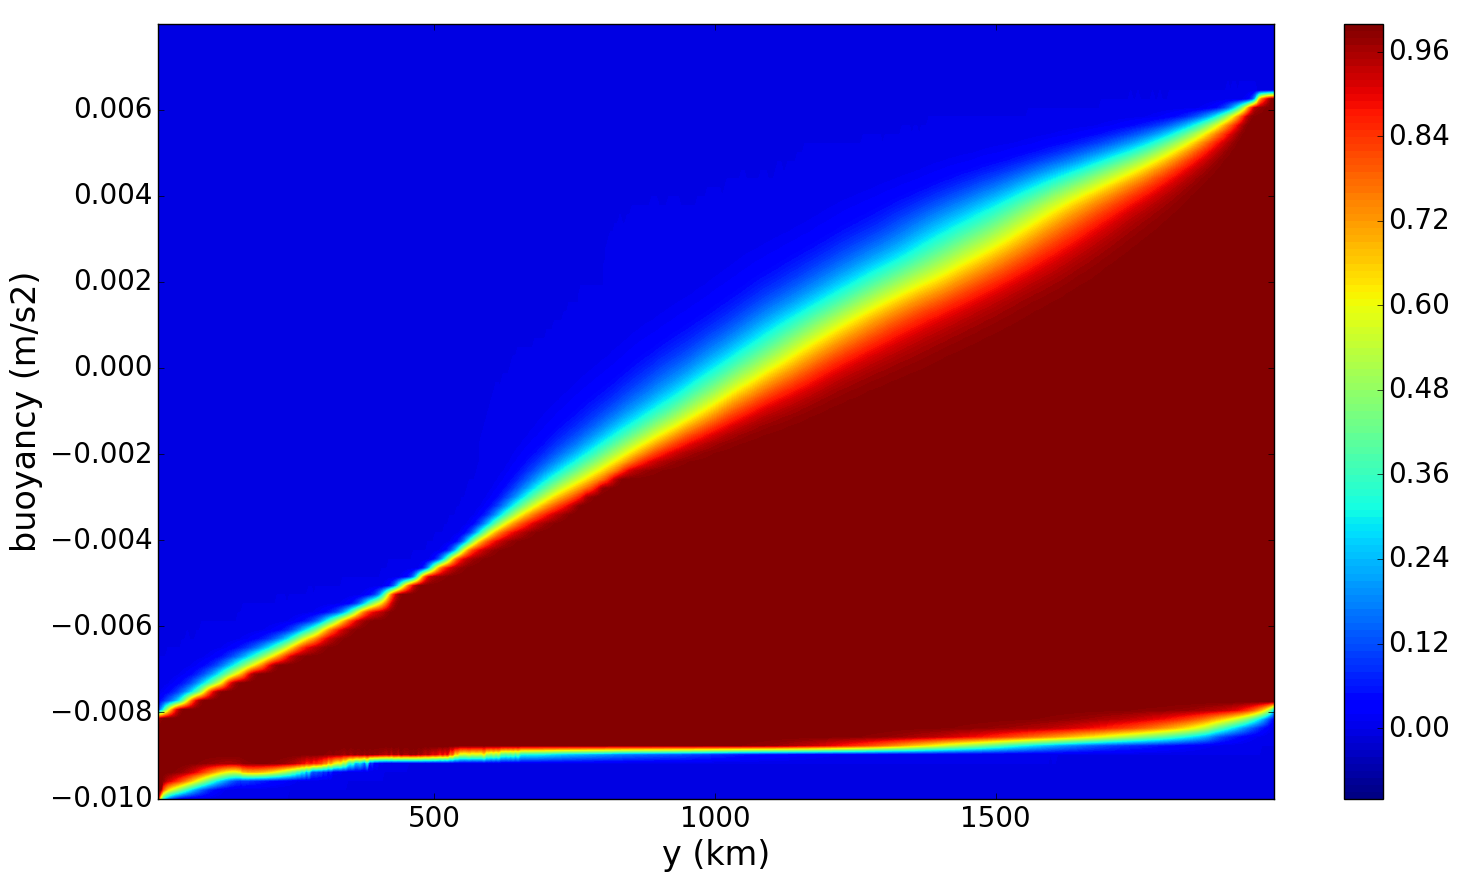

In [8]:
#convert buoyancyMask into an ocean mask
#plot buoyancyMask

buoyancyMaskEA = bAvgData.variables['buoyancyMaskEA'][iTime,:]
buoyancyMaskEA = buoyancyMaskEA.reshape(nY,nX,nBuoyancyLayers)
print buoyancyMaskEA.shape

#oceanMask (0,1)
oceanMask=[]
for j in range (0,nY):
    for i in range (0,nX):
        for k in range (0,nBuoyancyLayers):
            if buoyancyMaskEA[j,i,k]<threshold:
                oceanMask.append(0.0)
            else:
                oceanMask.append(1.0)

oceanMask = np.array(oceanMask)
oceanMask = oceanMask.reshape(nY,nX,nBuoyancyLayers)

#sum
sumData_buoyancyMaskEA = np.sum(buoyancyMaskEA, axis=1);
sumData_buoyancyMaskEA = np.divide(sumData_buoyancyMaskEA,nX)
colorLevels_buoyancyMaskEA = linspace(-0.1, 1.0, 111)
contourLevels_buoyancyMaskEA = [0.001, 0.01, 0.10, 0.25, 0.50, 0.95, 1.0]

#plot
plt.contourf(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=colorLevels_buoyancyMaskEA);
plt.colorbar();
#plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, linewidths=2, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

(460, 200, 100)


/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


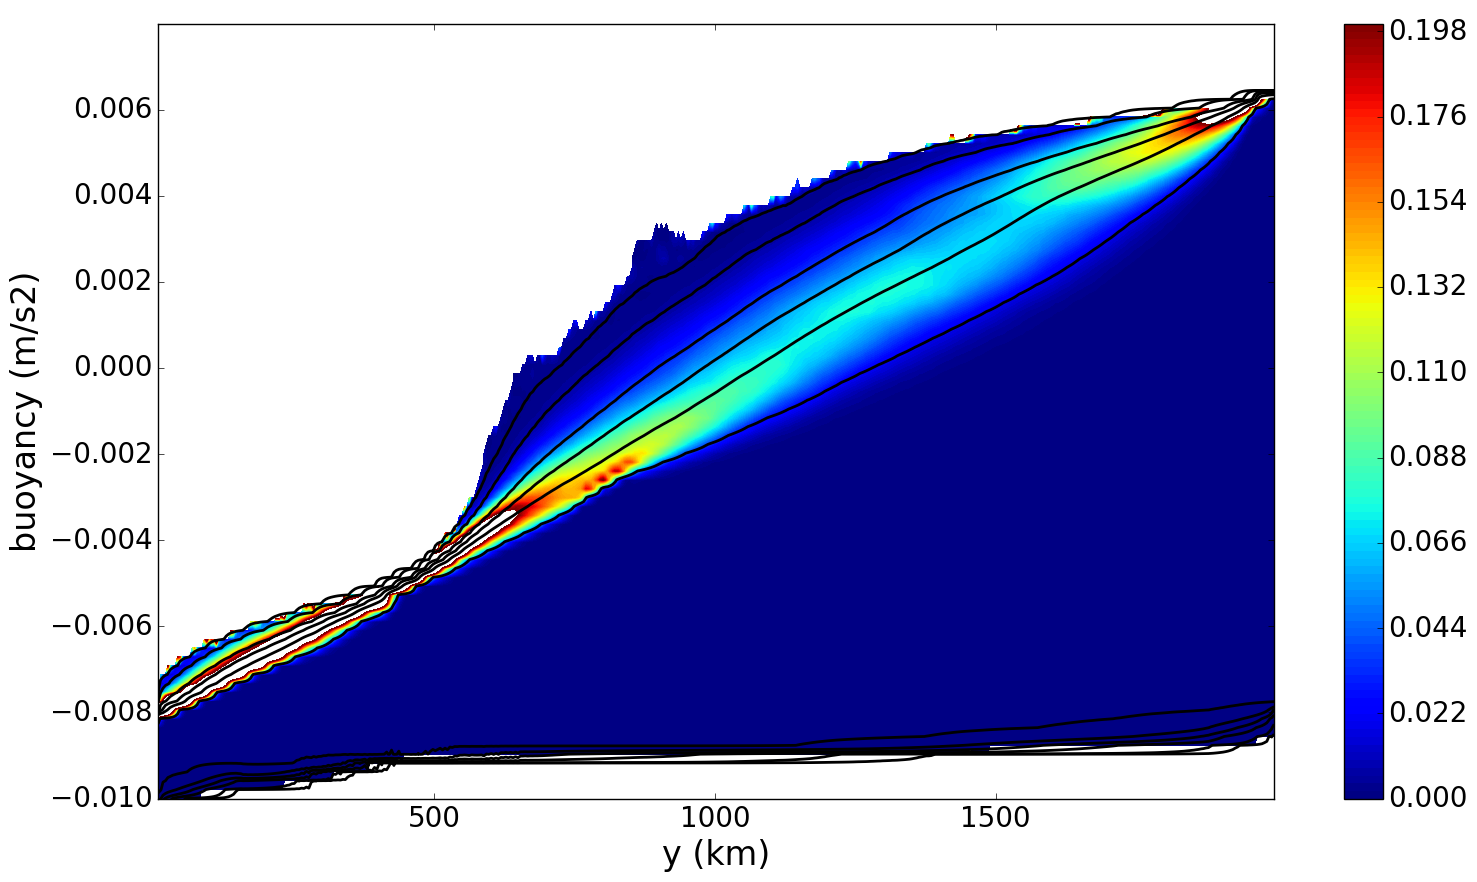

In [9]:
#find how often a given layer is at the surface
atSurface = zeros_like(buoyancyMaskEA)

#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(0,nBuoyancyLayers-1):
    atSurface[:,:,iBuoyancy]=buoyancyMaskEA[:,:,iBuoyancy+1]-buoyancyMaskEA[:,:,iBuoyancy]
    
#eliminate values at outcropping at bottom of domain
workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)
print atSurface.shape

#mask to eliminate infrequent events
#atSurface = np.multiply(atSurface,oceanMask)

#sum
sumData_atSurface = np.sum(atSurface, axis=1);
sumData_atSurface = np.divide(sumData_atSurface,np.sum(oceanMask, axis=1))

atSurfaceColors = linspace(0.0, 0.2, 101)
atSurfaceContours = [0.01, 0.03, 0.05, 0.07, 0.09, .11]

plt.contourf(yPosition, bPosition, sumData_atSurface.T,levels=atSurfaceColors);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=2);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

#currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
#                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
#                                fill=False, edgecolor="black", linewidth=3))

(460, 200, 100)


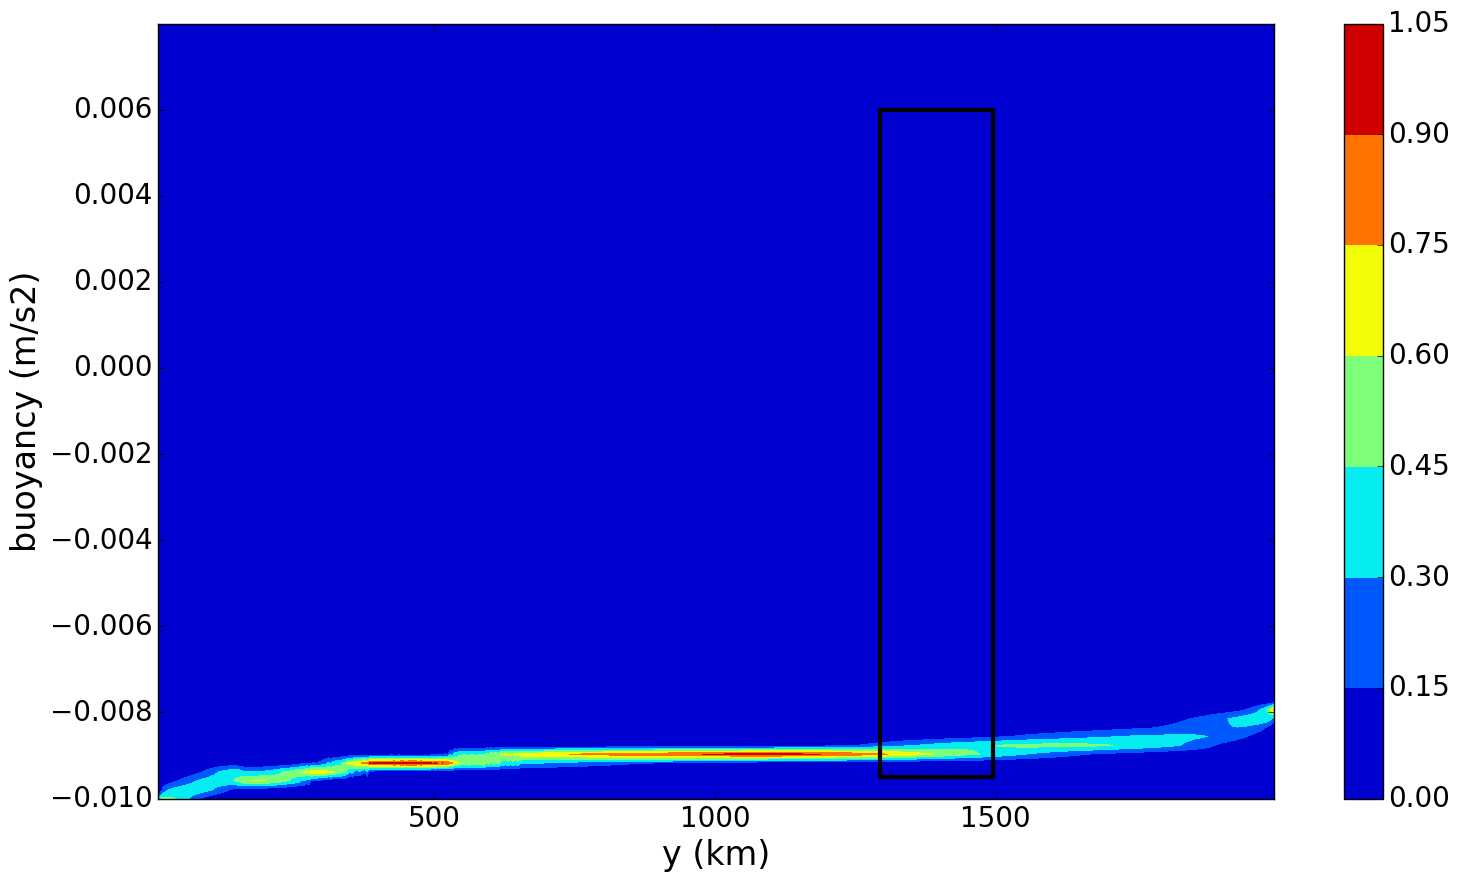

In [10]:
#find how often a given layer is at the bottom
atBottom = zeros_like(buoyancyMaskEA)

#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(nBuoyancyLayers-1,0,-1):
    atBottom[:,:,iBuoyancy]=buoyancyMaskEA[:,:,iBuoyancy-1]-buoyancyMaskEA[:,:,iBuoyancy]
    
#eliminate values at outcropping at bottom of domain
workZeros = zeros_like(atBottom)
atBottom = np.where(atBottom>0, atBottom, workZeros)
print atBottom.shape

#mask to eliminate infrequent events
#atBottom = np.multiply(atBottom,oceanMask)

#sum
sumData_atBottom = np.sum(atBottom, axis=1);
sumData_atBottom = np.divide(sumData_atBottom,nX)

atBottomColors = linspace(0.0, 0.1, 101)
#atBottomContours = [0.01, 0.03, 0.05, 0.07, 0.09, .11]

plt.contourf(yPosition, bPosition, sumData_atBottom.T);
plt.colorbar();
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


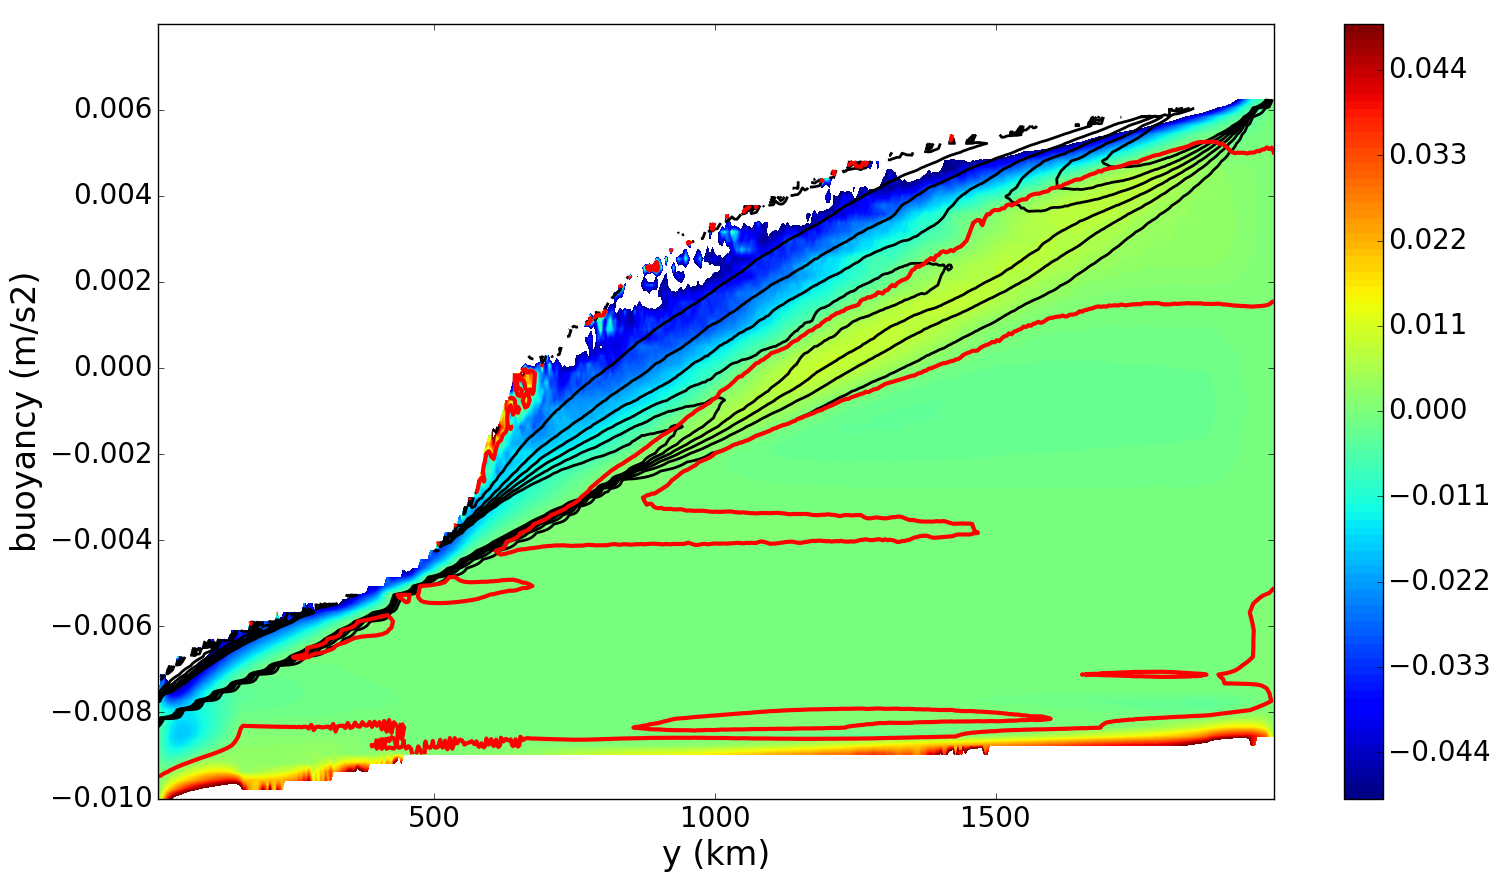

In [11]:
vTWA = bAvgData.variables['vTWA'][iTime,:]
vTWA = vTWA.reshape(nY,nX,nBuoyancyLayers)
vTWA = np.multiply(vTWA,oceanMask)

#sum
sumData_vTWA = np.sum(vTWA, axis=1);
sumData_vTWA = np.divide(sumData_vTWA,np.sum(oceanMask, axis=1))

vTWAColors = linspace(-0.05, 0.05, 101)
vTWAContours = [0.0]

plt.contourf(yPosition, bPosition, sumData_vTWA.T,levels=vTWAColors);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_atSurface.T, levels=atSurfaceContours, colors='black', linewidths=2);
plt.contour(yPosition, bPosition, sumData_vTWA.T, levels=vTWAContours, colors='red', linewidths=3);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


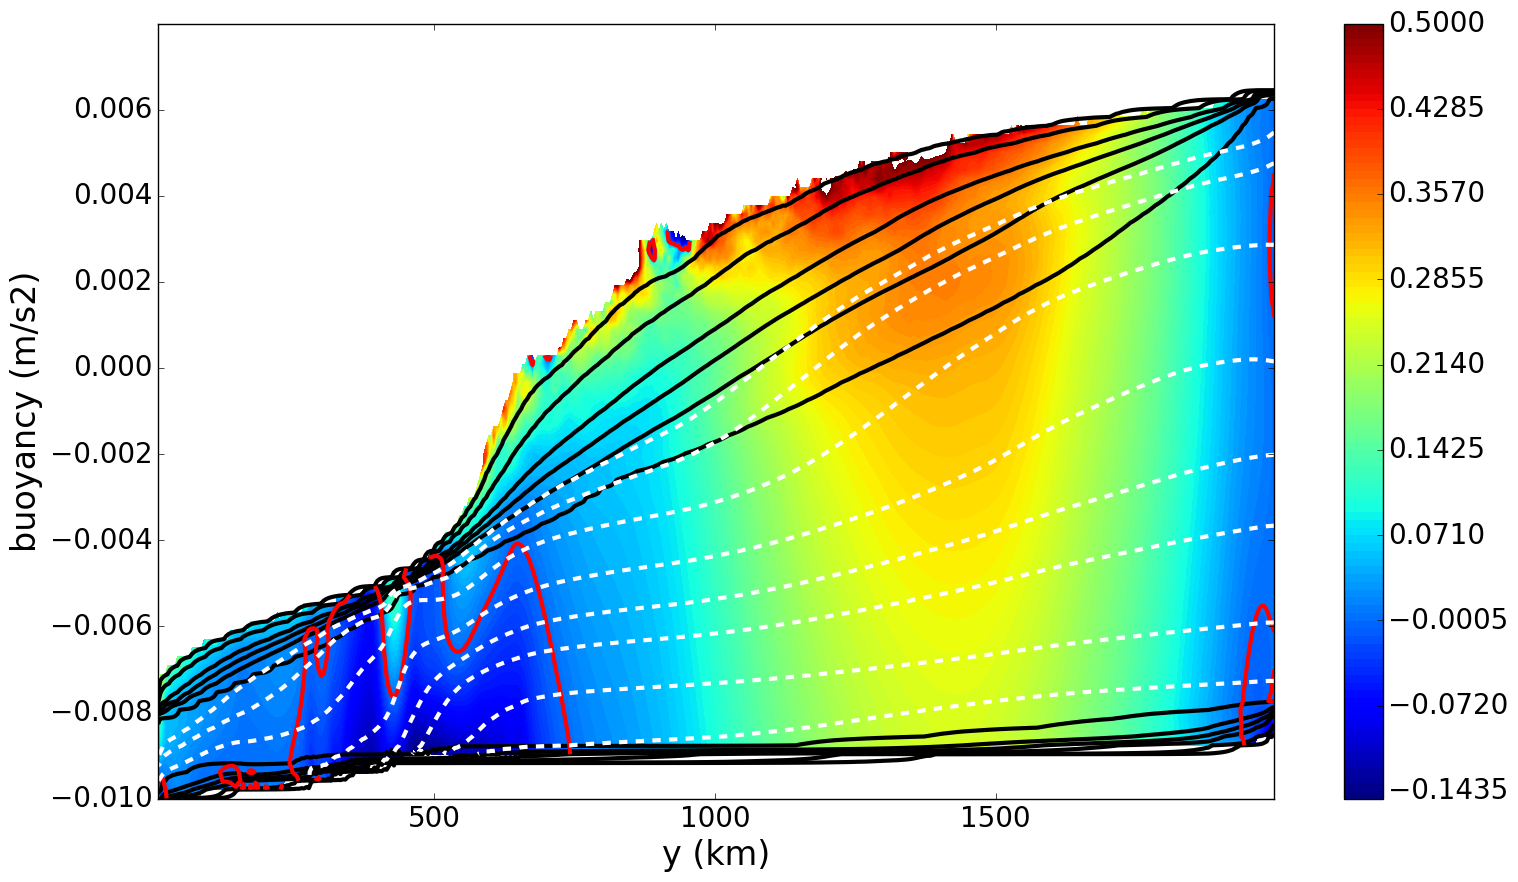

In [12]:
uTWA = bAvgData.variables['uTWA'][iTime,:]
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)
uTWA = np.multiply(uTWA,oceanMask)

#sum
sumData_uTWA = np.sum(uTWA, axis=1);
sumData_uTWA = np.divide(sumData_uTWA,np.sum(oceanMask, axis=1))

uTWAColors = linspace(-0.15, 0.5, 101)
uTWAContours = [0.0]

#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)
heightMidBuoyCoorEA = np.multiply(heightMidBuoyCoorEA,oceanMask)

sumData_heightMidBuoyCoorEA = np.sum(heightMidBuoyCoorEA, axis=1);
sumData_heightMidBuoyCoorEA = np.divide(sumData_heightMidBuoyCoorEA,np.sum(oceanMask, axis=1))
heightContours = [-2000, -1500, -1000, -750, -500, -250, -100, -50]

plt.contourf(yPosition, bPosition, sumData_uTWA.T,levels=uTWAColors);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, linewidths=3, colors='k');
plt.contour(yPosition, bPosition, sumData_uTWA.T, levels=uTWAContours, colors='red', linewidths=3);
plt.contour(yPosition, bPosition, sumData_heightMidBuoyCoorEA.T, levels=heightContours, colors='white', linewidths=3);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in divide


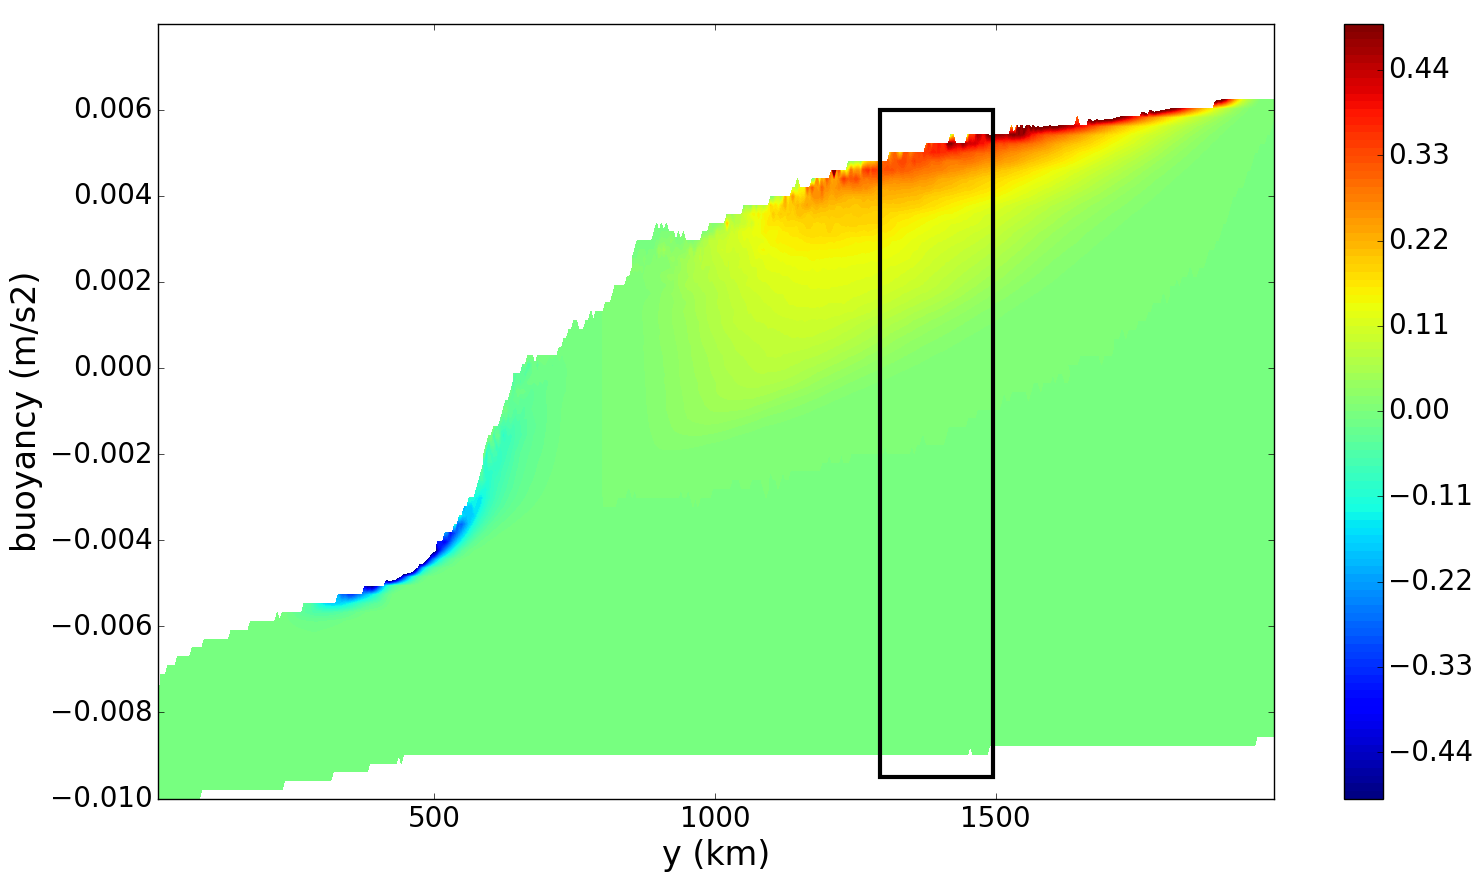

In [13]:
#get windStressZonal
windStressZonal = forcingData.variables['windStressZonal'][:]
windStressZonal = np.divide(windStressZonal.reshape(nY,nX), config_density0)

#get thickness
workBig = ones_like(atSurface)*1.0e10
sigmaEA = bAvgData.variables['sigmaEA'][:]
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)
sigmaEA = np.where(buoyancyMaskEA>threshold, sigmaEA, workBig)

#recompute atSurface
#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(0,nBuoyancyLayers-1):
    atSurface[:,:,iBuoyancy]=buoyancyMaskEA[:,:,iBuoyancy+1]-buoyancyMaskEA[:,:,iBuoyancy]
    
#eliminate values at outcropping at bottom of domain
workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)

#compute buoyancy width
db = zeros_like(potentialDensityTopRef)
for iBuoyancy in range(0,nBuoyancyLayers-1):
    db[iBuoyancy] = potentialDensityTopRef[iBuoyancy+1]-potentialDensityTopRef[iBuoyancy]
    
#patch up the bottom
db[nBuoyancyLayers-1] =  db[nBuoyancyLayers-2]

#get the correct units
db = db * gravity / config_density0

#distribute wind stress across layers
windStressZonalLayer = zeros_like(atSurface)
for iBuoyancy in range(0,nBuoyancyLayers-1):
    windStressZonalLayer[:,:,iBuoyancy] = np.multiply(windStressZonal[:,:], atSurface[:,:,iBuoyancy])
    windStressZonalLayer[:,:,iBuoyancy] = np.divide(windStressZonalLayer[:,:,iBuoyancy], sigmaEA[:,:,iBuoyancy])
    windStressZonalLayer[:,:,iBuoyancy] = np.divide(windStressZonalLayer[:,:,iBuoyancy], db[iBuoyancy])

#mask
windStressZonalLayer = np.multiply(windStressZonalLayer,oceanMask)

#sum
sumData_windStress = np.sum(windStressZonalLayer, axis=1);
sumData_windStress = np.divide(sumData_windStress,np.sum(oceanMask, axis=1))

sumData_sigmaEA = np.sum(sigmaEA, axis=1);
sumData_sigmaEA = np.divide(sumData_sigmaEA,np.sum(oceanMask, axis=1))

#plotting
windStressZonalLayerColors = linspace(-0.5, 0.5, 101)
windStressZonalLayerContours = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

plt.contourf(yPosition, bPosition, 86400.0*sumData_windStress.T, levels=windStressZonalLayerColors);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_windStress.T, levels=windStressZonalLayerContours, linewidths=2, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in divide
/turquoise/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in divide


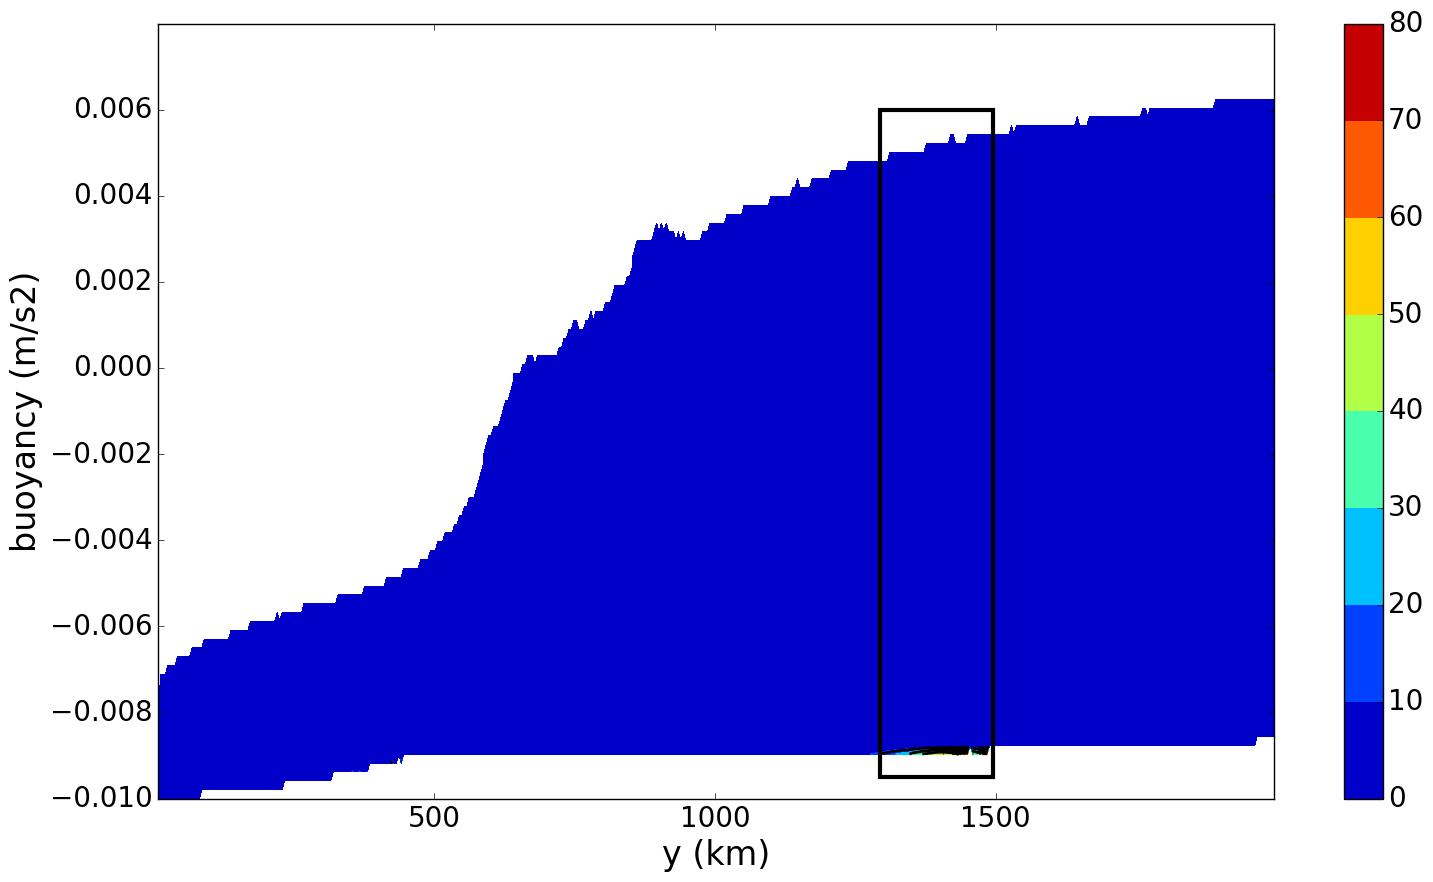

In [14]:
#compute bottom drag force

#get thickness
workBig = ones_like(atSurface)*1.0e10
sigmaEA = bAvgData.variables['sigmaEA'][:]
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)
sigmaEA = np.where(buoyancyMaskEA>threshold, sigmaEA, workBig)

#get u
uTWA = bAvgData.variables['uTWA'][:]
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)

#get uu
uusigmaEA = bAvgData.variables['uusigmaEA'][:]
uusigmaEA = uusigmaEA.reshape(nY,nX,nBuoyancyLayers)

#get vv
vvsigmaEA = bAvgData.variables['vvsigmaEA'][:]
vvsigmaEA = vvsigmaEA.reshape(nY,nX,nBuoyancyLayers)

#get mean heights
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][:]
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

#bottom drag
bottomDrag = zeros_like(atBottom)

#build up terms in drag formula
work1 = zeros_like(uTWA)
work1 = np.multiply(uTWA,uTWA)
work1 = np.divide(work1,sigmaEA)
#work1 = np.divide(work1,sigmaEA)
#work1 = np.multiply(work1,oceanMask)

#compute buoyancy width
db = zeros_like(potentialDensityTopRef)
for iBuoyancy in range(0,nBuoyancyLayers-1):
    db[iBuoyancy] = potentialDensityTopRef[iBuoyancy+1]-potentialDensityTopRef[iBuoyancy]
    
#patch up the bottom
db[nBuoyancyLayers-1] =  db[nBuoyancyLayers-2]

#get the correct units
db = db * gravity / config_density0

#get layer thicknesses measured in meters
dz = zeros_like(uTWA)
for iBuoyancy in range(1,nBuoyancyLayers-1):
    dz[:,:,iBuoyancy] = np.subtract(heightMidBuoyCoorEA[:,:,iBuoyancy-1], heightMidBuoyCoorEA[:,:,iBuoyancy+1])
    dz[:,:,iBuoyancy] = np.multiply(dz[:,:,iBuoyancy], 0.5)
    bottomDrag[:,:,iBuoyancy] = np.divide(work1[:,:,iBuoyancy], db[iBuoyancy])
    
dz = np.where(buoyancyMaskEA>threshold, dz, workBig)
        
#distribute wind stress across layers
bottomDrag = np.multiply(bottomDrag, atBottom)
bottomDrag = 3.0e-3 * bottomDrag

#mask and sum
bottomDrag = np.multiply(bottomDrag,oceanMask)
sumData_bottomDrag = np.sum(bottomDrag, axis=1);
sumData_bottomDrag = np.divide(sumData_bottomDrag,np.sum(oceanMask, axis=1))

dz = np.multiply(dz,oceanMask)
sumData_work1 = np.sum(dz, axis=1);
sumData_work1 = np.divide(sumData_work1,np.sum(oceanMask, axis=1))

#plotting
bottomDragLayerColors = linspace(-0.25, 0.25, 101)
bottomDragLayerContours = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

plt.contourf(yPosition, bPosition, sumData_bottomDrag.T*86400);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_bottomDrag.T, \
            linewidths=2, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))


(460, 200)
(460, 200)


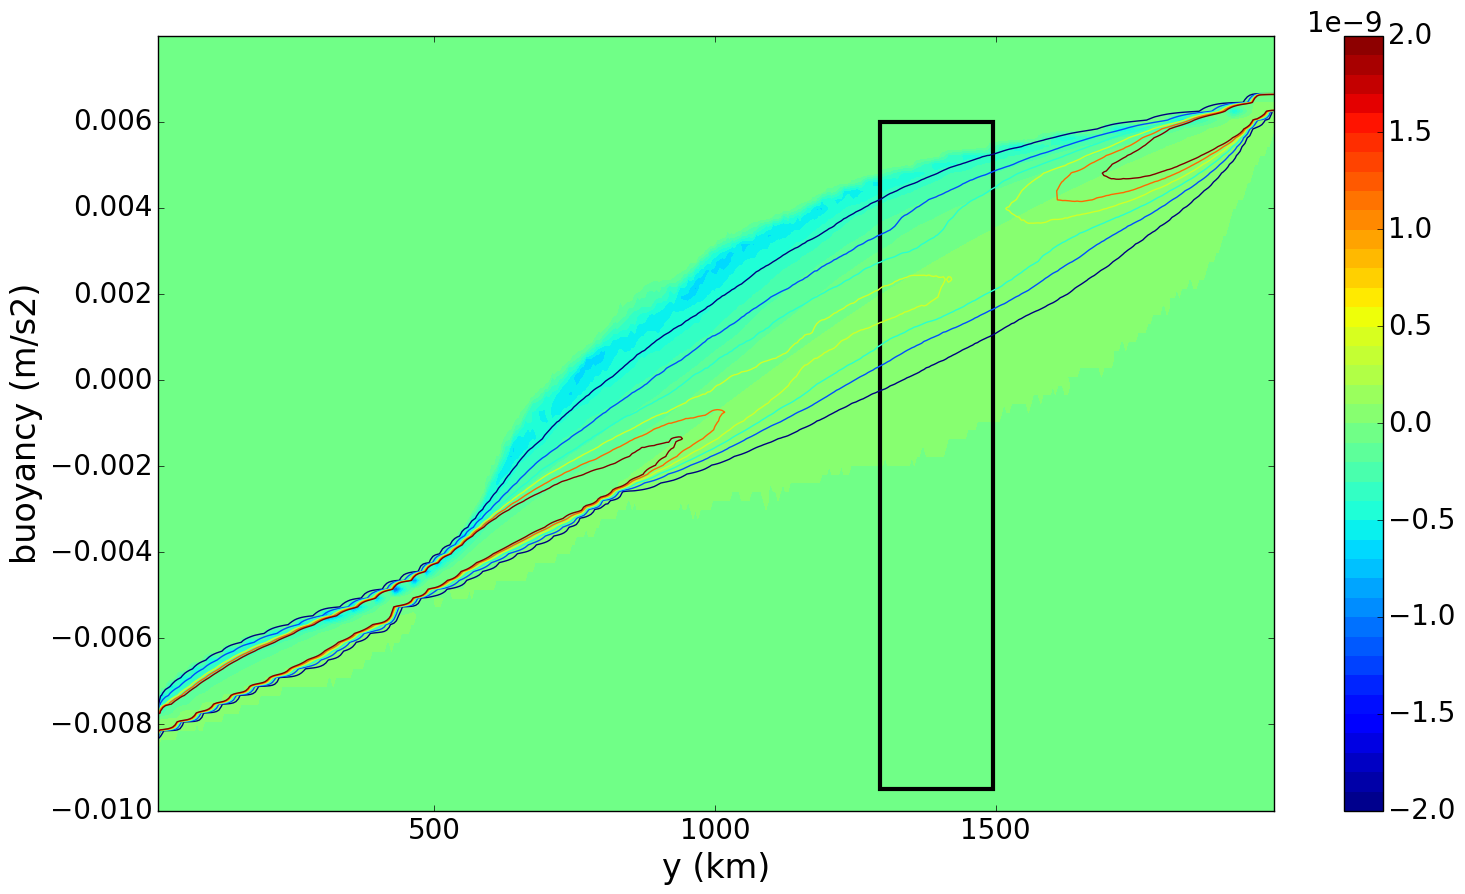

In [15]:
#compute db/dt

#read in restoring temperature and piston velocity
temperatureSurfaceRestoringValue = forcingData.variables['temperatureSurfaceRestoringValue'][iTime,:]
temperatureSurfaceRestoringValue = temperatureSurfaceRestoringValue.reshape(nY,nX)
print temperatureSurfaceRestoringValue.shape

temperaturePistonVelocity = forcingData.variables['temperaturePistonVelocity'][iTime,:]
temperaturePistonVelocity = temperaturePistonVelocity.reshape(nY,nX)
print temperaturePistonVelocity.shape

workRef = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLayers):
    workRef[:,:,iBuoyancy]=temperatureRef[iBuoyancy]

bDot = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLayers):
    bDot[:,:,iBuoyancy] = -(workRef[:,:,iBuoyancy]-temperatureSurfaceRestoringValue[:,:])   #delta T
    bDot[:,:,iBuoyancy] = np.multiply(bDot[:,:,iBuoyancy], temperaturePistonVelocity[:,:]) #T flux
    bDot[:,:,iBuoyancy] = bDot[:,:,iBuoyancy] * config_eos_linear_alpha                    #rho flux
    bDot[:,:,iBuoyancy] = np.multiply(bDot[:,:,iBuoyancy], atSurface[:,:,iBuoyancy])      #weighted by occurence
    bDot[:,:,iBuoyancy] = gravity / config_density0 *  bDot[:,:,iBuoyancy]                 #get units correct

#at this point bDot is buoyancy * piston velocity, i.e. buoyancy flux (m2/s3)
#need to divide by (sigma * db == dz) to get units of m/s3
for iBuoyancy in range(0,nBuoyancyLayers):
    dz = np.multiply(db[iBuoyancy], sigmaEA[:,:,iBuoyancy])
    bDot[:,:,iBuoyancy] = np.divide(bDot[:,:,iBuoyancy], dz[:,:])
    
sumData = np.sum(bDot, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

scaling = 1.0e-9
bDotColorLevels = linspace(-2.0, 2.0, 41)
bDotColorLevels = scaling * bDotColorLevels

plt.contourf(yPosition, bPosition, sumData.T, levels=bDotColorLevels);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, levels=atSurfaceContours);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

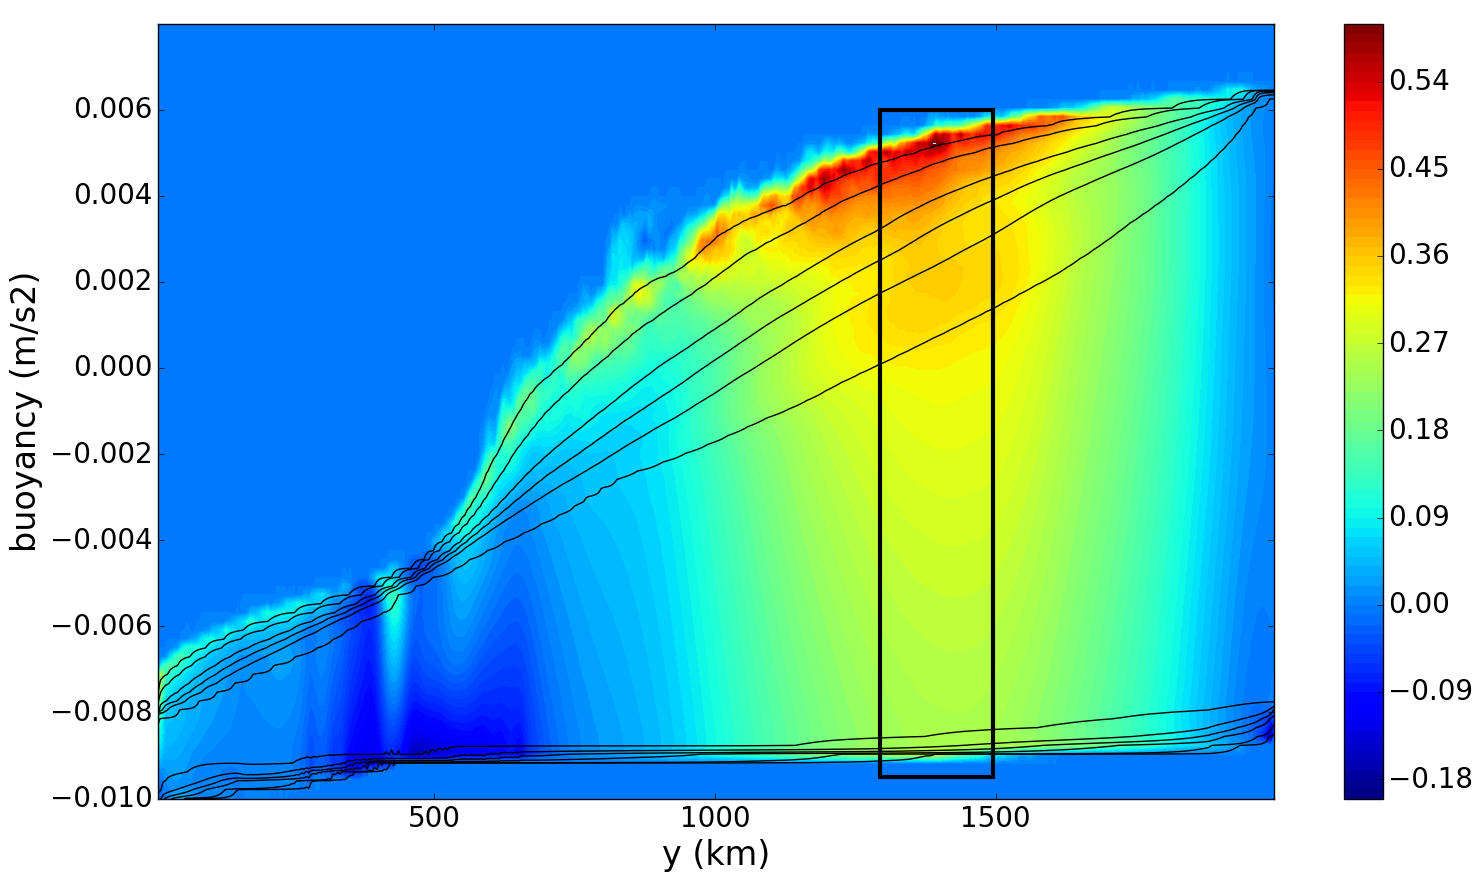

In [16]:
#read uTWA
uTWA = bAvgData.variables['uTWA'][iTime,:,:]
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)

sumData = np.sum(uTWA, axis=1);
sumData = np.divide(sumData,nX)

sumDatabDot = np.sum(86400*bDot, axis=1);
sumDatabDot = np.divide(sumDatabDot,nX)

uTWAColorLevels = linspace(-0.2, 0.6, 81)
bDotContourLevels = linspace(-0.1, 0.1, 11)
plt.contourf(yPosition, bPosition, sumData.T, levels=uTWAColorLevels);
plt.colorbar();
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidth=5);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

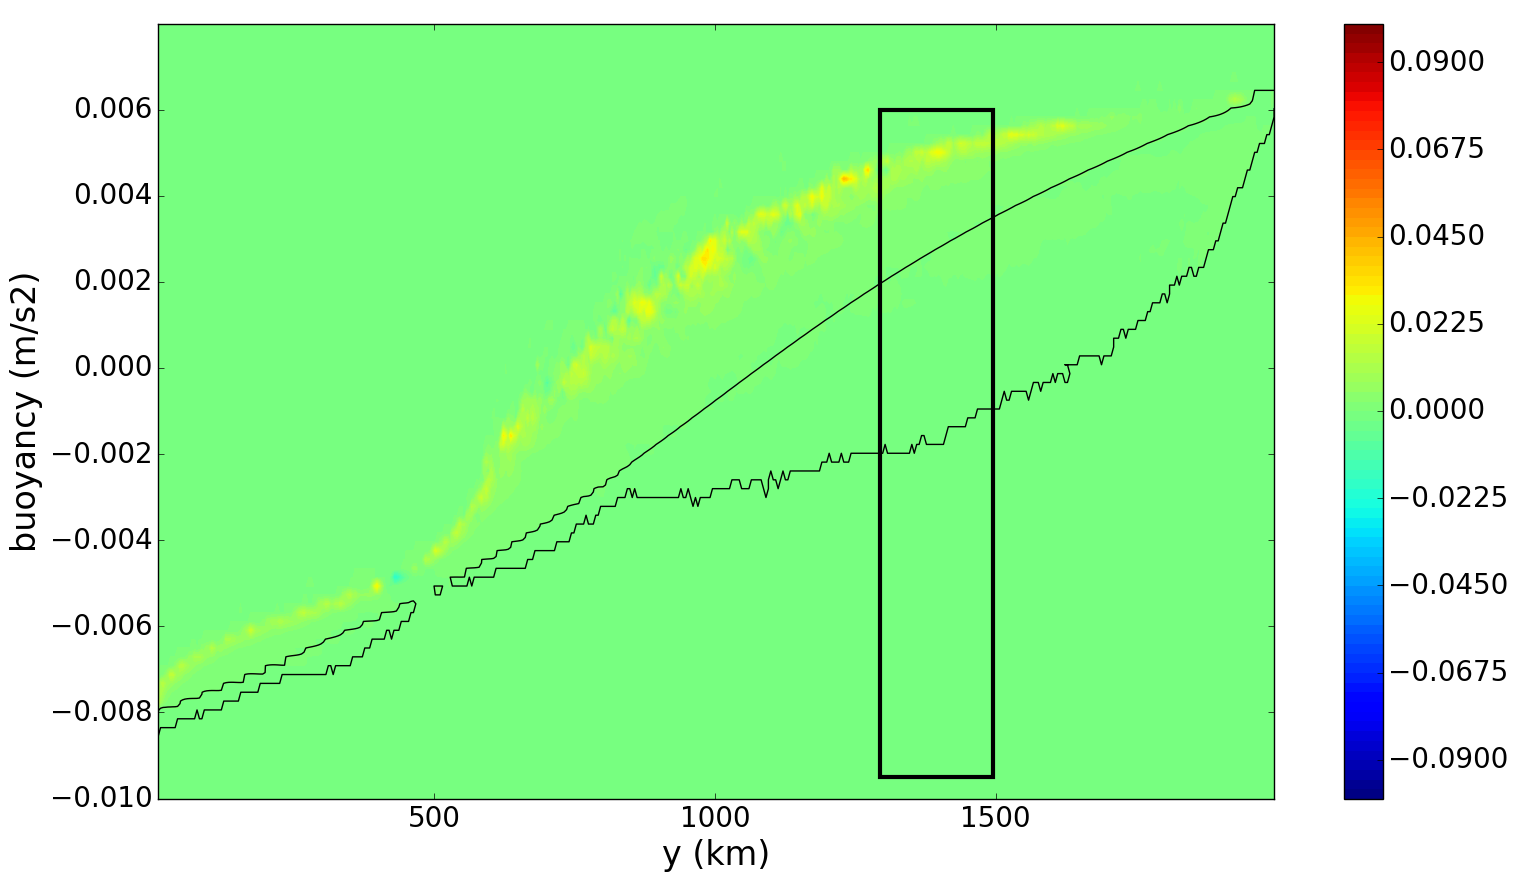

In [17]:
#compute tendency of zonal velocity due to diabatic "advection"

#compute bDot * du/db
verticalAdvection = zeros_like(bDot)
for iBuoyancy in range(1,nBuoyancyLayers-1):
    verticalAdvection[:,:,iBuoyancy] = (uTWA[:,:,iBuoyancy-1]-uTWA[:,:,iBuoyancy+1])/db[iBuoyancy]
    verticalAdvection[:,:,iBuoyancy] = -np.multiply(verticalAdvection[:,:,iBuoyancy], bDot[:,:,iBuoyancy])
    
sumData = np.sum(86400*verticalAdvection, axis=1);
sumData = np.divide(sumData,nX)

sumDatabDot = np.sum(86400*bDot, axis=1);
sumDatabDot = np.divide(sumDatabDot,nX)

vvColorLevels = linspace(-0.1, 0.1, 81)
bDotContourLevels = linspace(-0.1, 0.1, 11)
plt.contourf(yPosition, bPosition, sumData.T, levels=vvColorLevels);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDatabDot.T, levels=bDotContourLevels, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

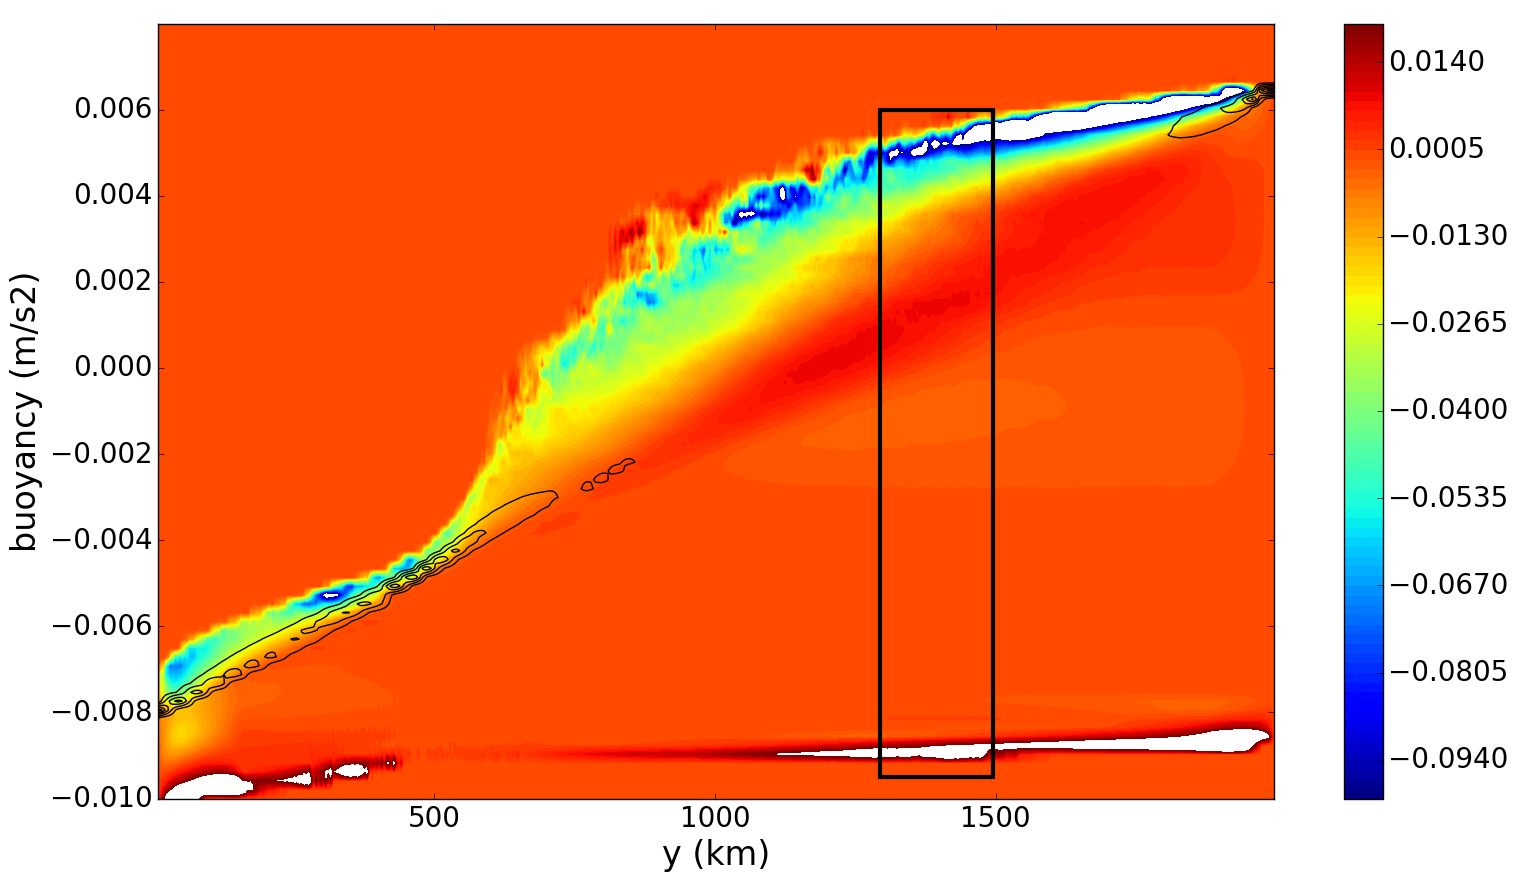

In [18]:
#vTWA

#read vTWA
vTWA = bAvgData.variables['vTWA'][iTime,:,:]
vTWA = vTWA.reshape(nY,nX,nBuoyancyLayers)

#read fCell
fCell = initData.variables['fCell'][:]
fCell = fCell.reshape(nY,nX)

#ErtelPV
ErtelPV = bAvgData.variables['ErtelPV'][iTime,:,:];
ErtelPV = ErtelPV.reshape(nY,nX,nBuoyancyLayers)

#de-weight to obtain absolute vorticity
ErtelPV = np.multiply(ErtelPV,sigmaEA)

sumData = np.sum(vTWA, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(yPosition, bPosition, sumData.T, levels=vTWAColorLevels);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

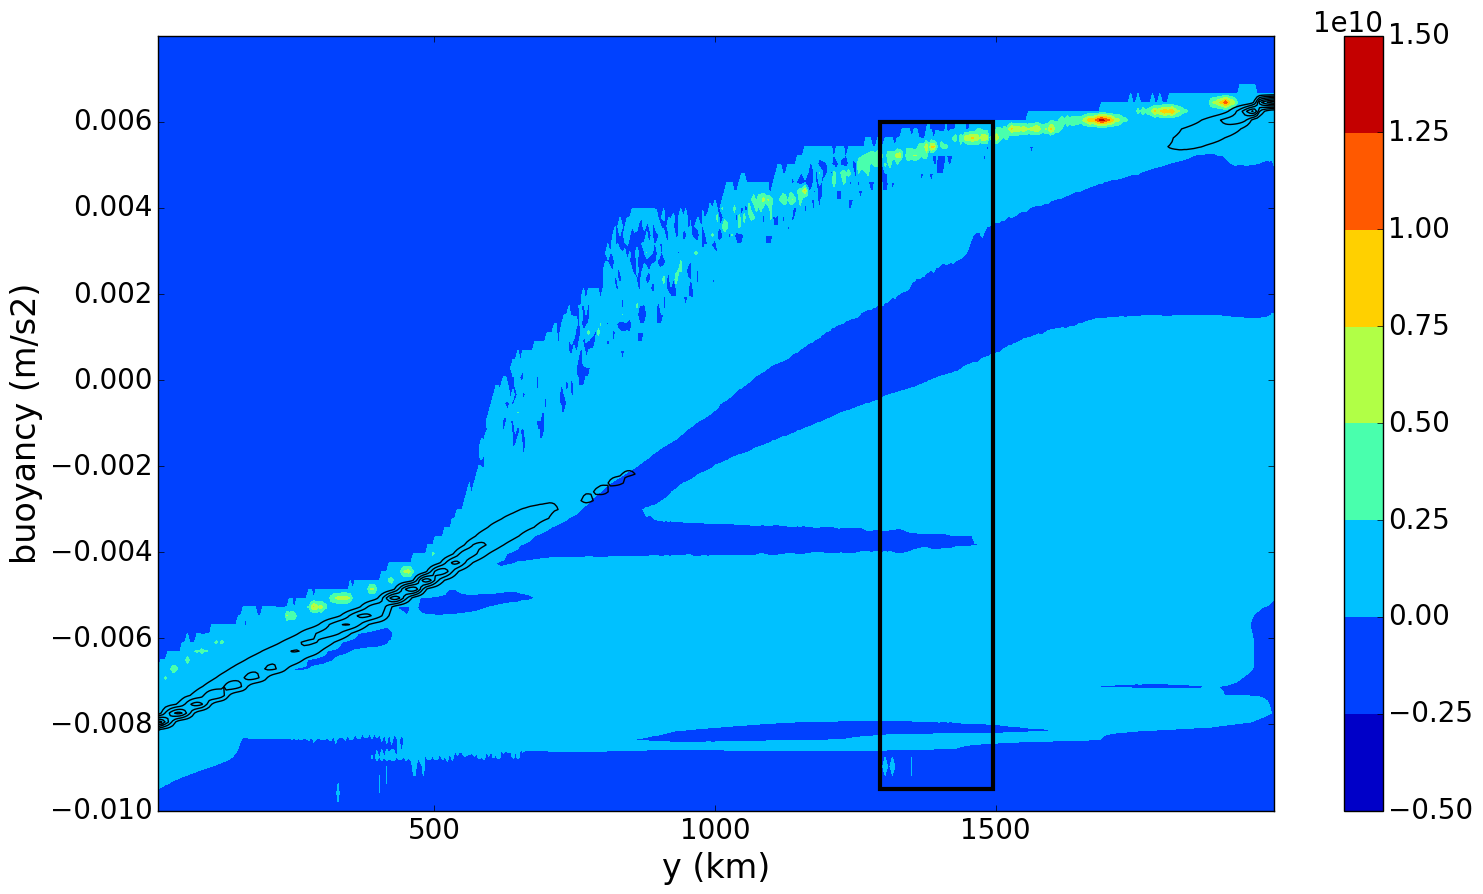

In [19]:
coriolisForce = zeros_like(vTWA)
for iBuoyancy in range(1,nBuoyancyLayers-1):
    coriolisForce[:,:,iBuoyancy] = np.multiply(vTWA[:,:,iBuoyancy], ErtelPV[:,:,iBuoyancy])
    
sumData = np.sum(coriolisForce, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(yPosition, bPosition, 86400*sumData.T);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

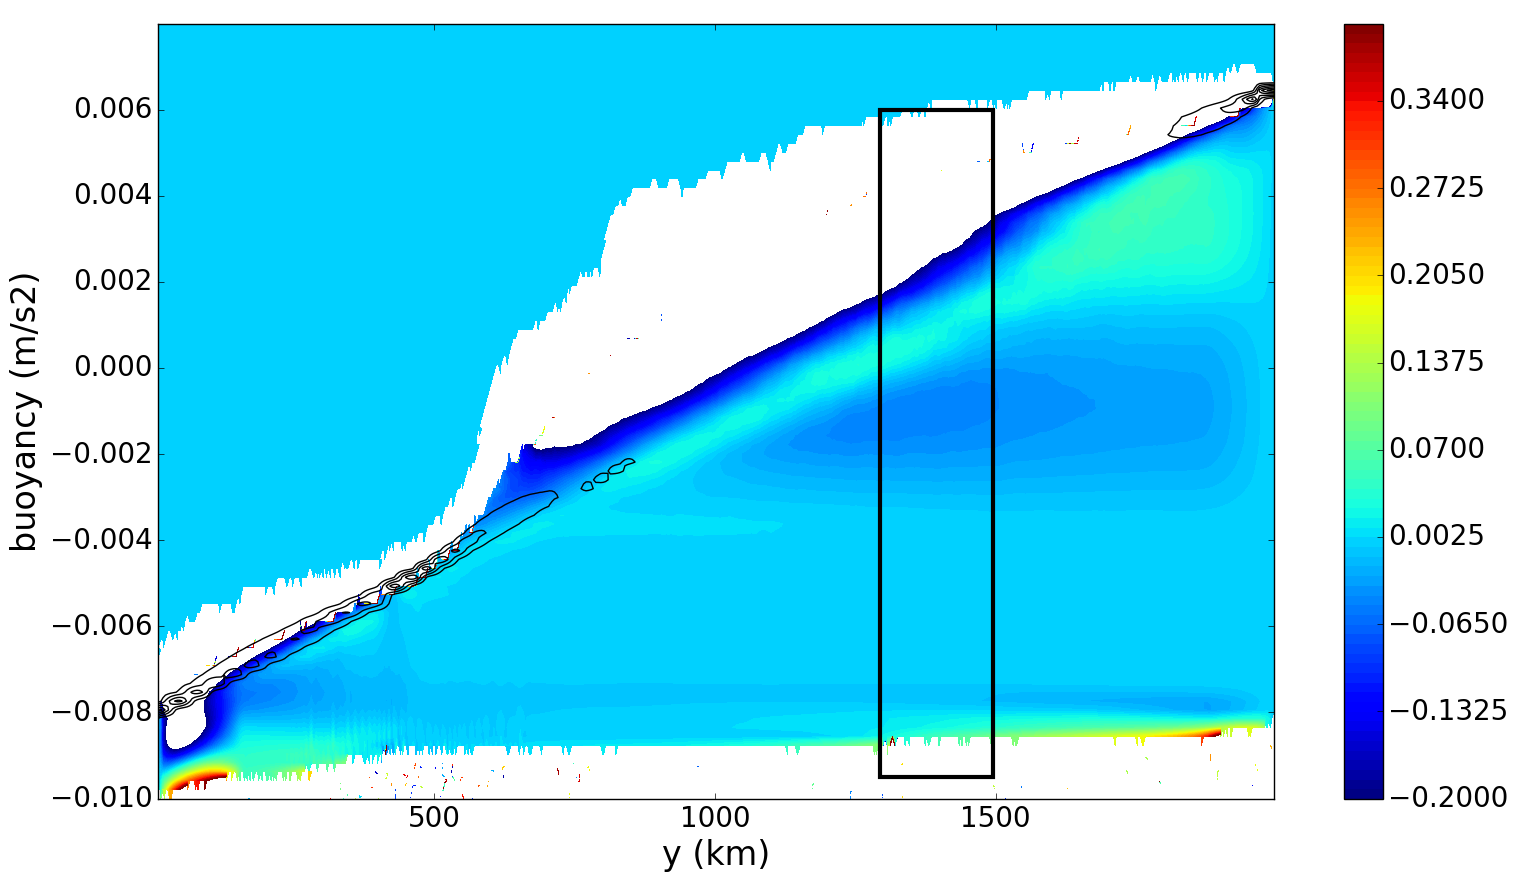

In [20]:
#vertical buoyancy flux - zonal direction
EPFT = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT = EPFT.reshape(nY,nX,nBuoyancyLayers)

# change sign ??
EPFT = -EPFT

EPFT = numpy.multiply(EPFT,sigmaEA)

#compute 1/sigmaEA d/db (vertical flux of zonal momentum)
eddyForcingVert = zeros_like(EPFT)
for iBuoyancy in range(1,nBuoyancyLayers-1):
    eddyForcingVert[:,:,iBuoyancy] = (EPFT[:,:,iBuoyancy-1]-EPFT[:,:,iBuoyancy+1])/db[iBuoyancy]

eddyForcingVert = np.divide(eddyForcingVert,sigmaEA)

sumData = np.sum(eddyForcingVert, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

vertFluxColorLevels = linspace(-0.2, 0.4, 81)
plt.contourf(yPosition, bPosition, 86400*sumData.T, levels=vertFluxColorLevels);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

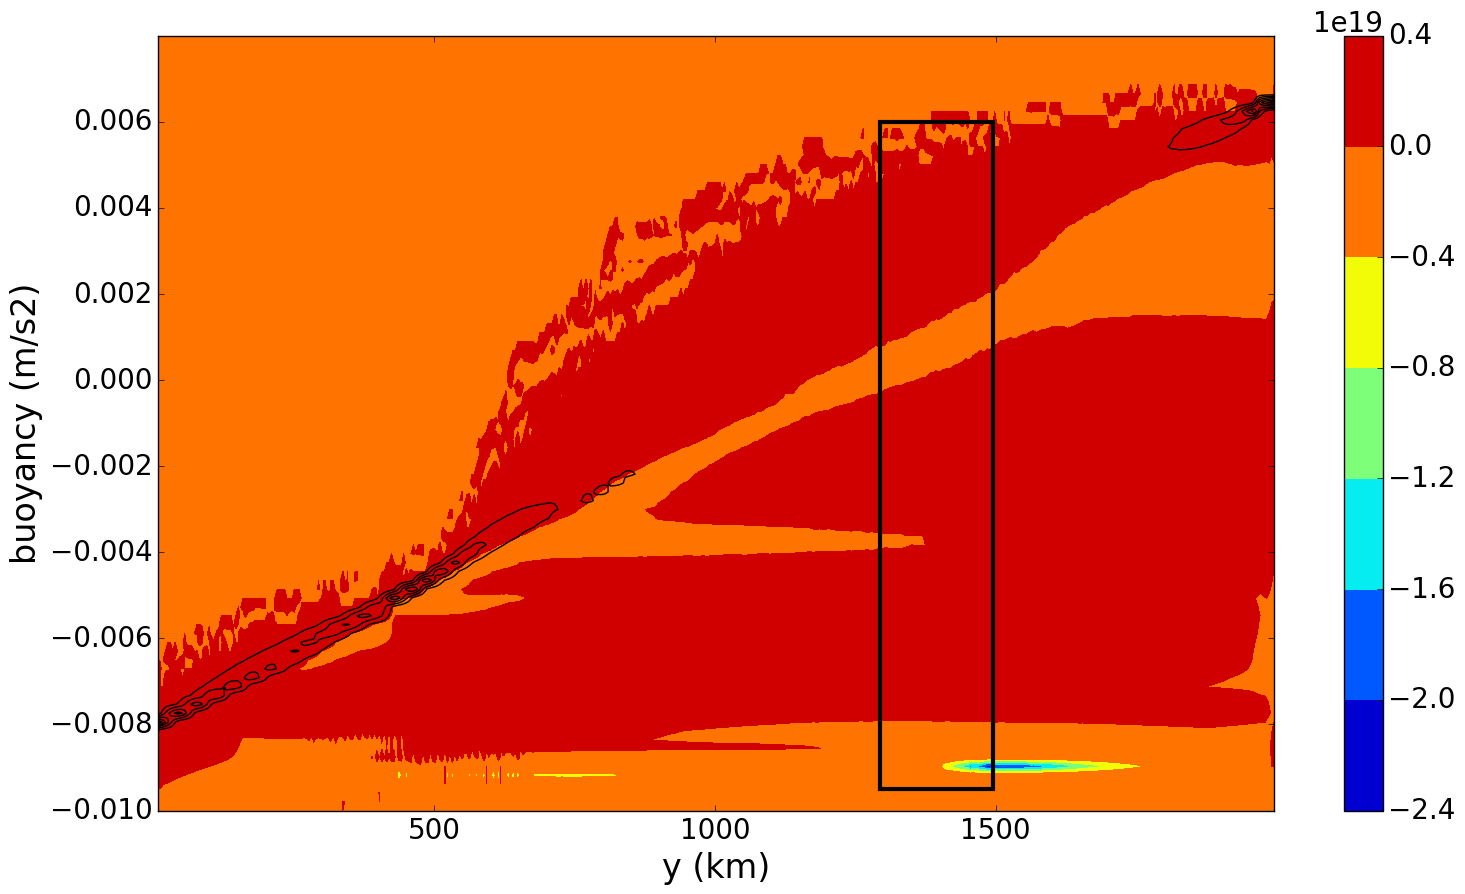

In [31]:
#vertical buoyancy flux - zonal direction
divEPFT = bAvgData.variables['divEPFT'][iTime,:,:,0];
divEPFT = divEPFT.reshape(nY,nX,nBuoyancyLayers)

divEPFT = np.multiply(divEPFT, oceanMask)

sumData = np.sum(divEPFT, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

vertFluxColorLevels = linspace(-0.2, 0.4, 81)
plt.contourf(yPosition, bPosition, 86400*sumData.T);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

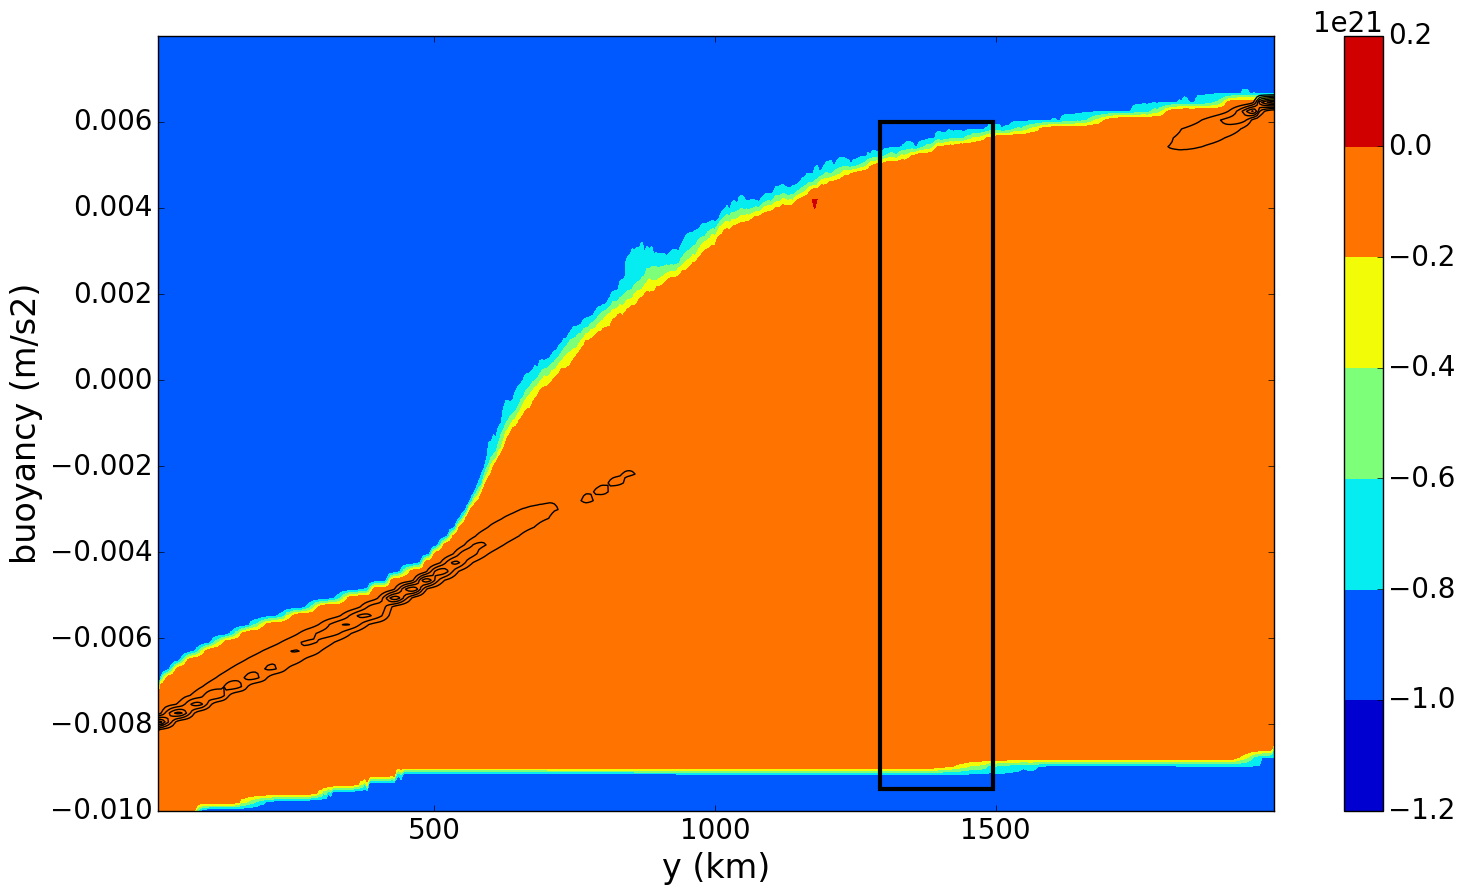

In [23]:
#ErtelPV
ErtelPV = bAvgData.variables['ErtelPV'][iTime,:,:];
ErtelPV = ErtelPV.reshape(nY,nX,nBuoyancyLayers)

#de-weight for plotting
ErtelPV = np.multiply(ErtelPV,sigmaEA)

sumData = np.sum(ErtelPV, axis=1);
sumData = np.divide(sumData,nX)

sumDataSurface = np.sum(atSurface, axis=1);
sumDataSurface = np.divide(sumDataSurface,nX)

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(yPosition, bPosition, sumData.T);
plt.colorbar();
plt.contour(yPosition, bPosition, sumDataSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

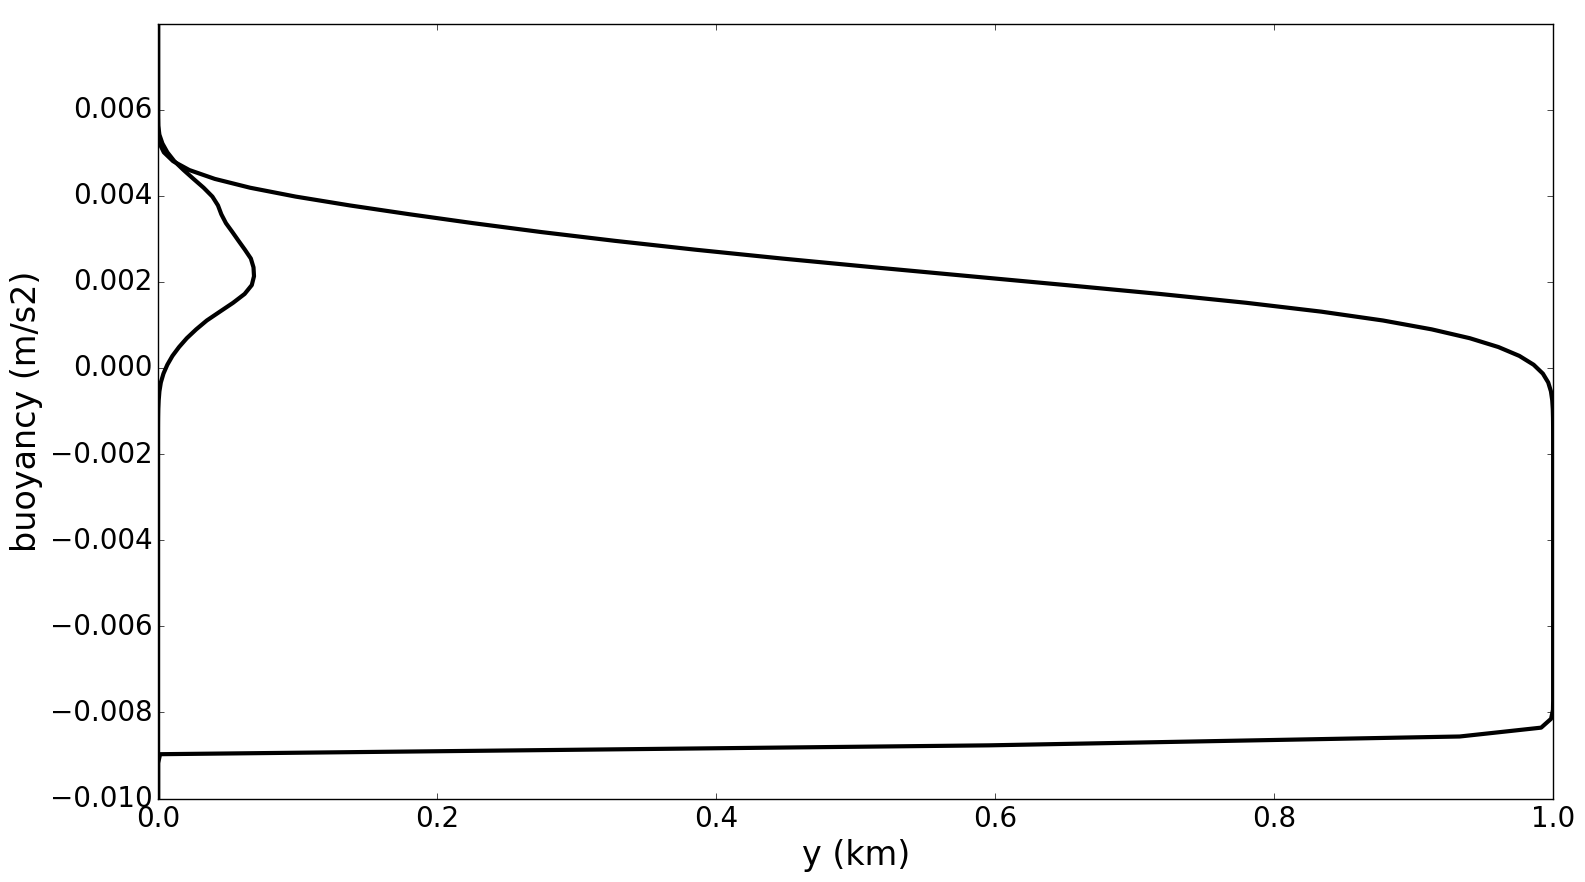

In [24]:
#plot FoC
avg_buoyancyMaskEA = zeros_like(buoyancyMaskEA)
avg_buoyancyMaskEA = buoyancyMaskEA[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_buoyancyMaskEA, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_buoyancyMaskEA = sumData

avg_atSurface = zeros_like(atSurface)
avg_atSurface = atSurface[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_atSurface, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_atSurface = sumData

plt.plot(avg_buoyancyMaskEA, bPosition, color='black', linewidth=3)
plt.plot(avg_atSurface, bPosition, color='black', linewidth=3)
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

ValueError: x and y must have same first dimension

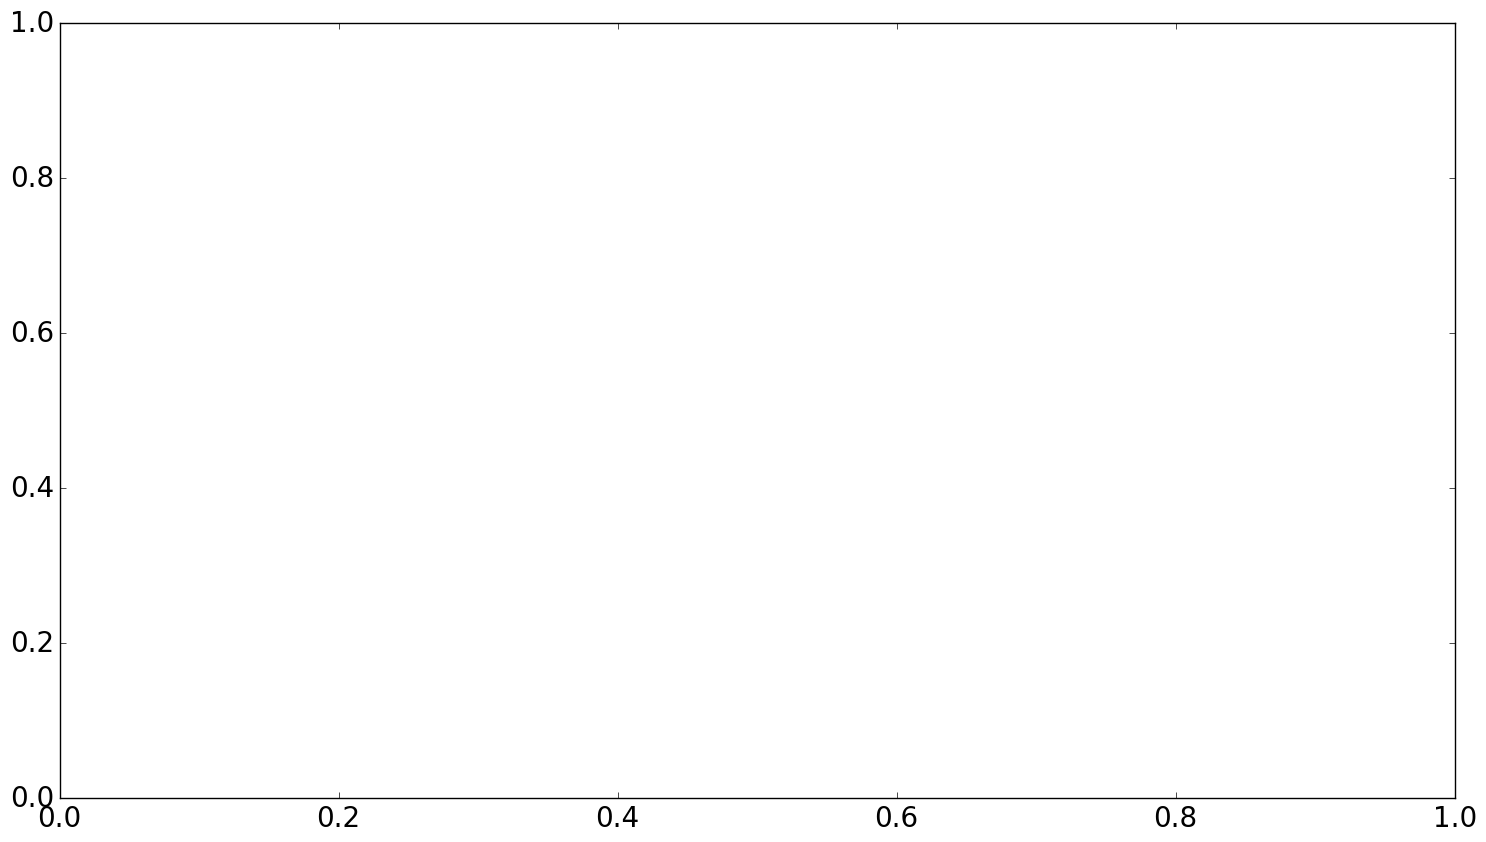

In [37]:
plt.plot(coriolisForce[index_yPositionMin,:,:].mean(axis=1),bPosition)

In [25]:
#depth of boundary layer
boundaryLayerDepth = zAvgData.variables['timeSeriesStats_avg_boundaryLayerDepth_1'][iTime,:];
boundaryLayerDepth = boundaryLayerDepth.reshape(nY,nX)
print boundaryLayerDepth.shape
print index_yPositionMin, index_yPositionMax, nX

avg_boundaryLayerDepth = zeros_like(boundaryLayerDepth)
avg_boundaryLayerDepth = boundaryLayerDepth[index_yPositionMin:index_yPositionMax,:]
sumData = np.sum(np.sum(avg_boundaryLayerDepth, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_boundaryLayerDepth = sumData

print 'boundary layer depth (m): ', avg_boundaryLayerDepth


KeyError: 'timeSeriesStats_avg_boundaryLayerDepth_1'

25 0.00336322368421 -23.0730917436
26 0.00315765350877 -29.9294290585
27 0.00295208333333 -38.0169510255
28 0.0027465131579 -47.4173019601
29 0.00254094298246 -58.1898717637
30 0.00233537280702 -70.3403383109
31 0.00212980263158 -83.6091092338
32 0.00192423245614 -97.8347851738
33 0.0017186622807 -112.833064263
34 0.00151309210526 -128.275337331
35 0.00130752192983 -143.827772276
36 0.00110195175439 -159.280926944
37 0.000896381578947 -174.516967212
38 0.00069081140351 -189.539440534
39 0.000485241228069 -204.349899189
40 0.000279671052632 -219.000063259
41 7.4100877195e-05 -233.549760904
42 -0.000131469298246 -248.091907863
43 -0.000337039473683 -262.741426604
44 -0.000542609649122 -277.629647237
45 -0.000748179824562 -292.900736956
46 -0.000953749999999 -308.693230553
47 -0.00115932017544 -325.140275119
48 -0.00136489035088 -342.38206817
49 -0.00157046052631 -360.570955802
50 -0.00177603070176 -379.875485749
51 -0.00198160087719 -400.480854162
52 -0.00218717105263 -422.590954274
53 -

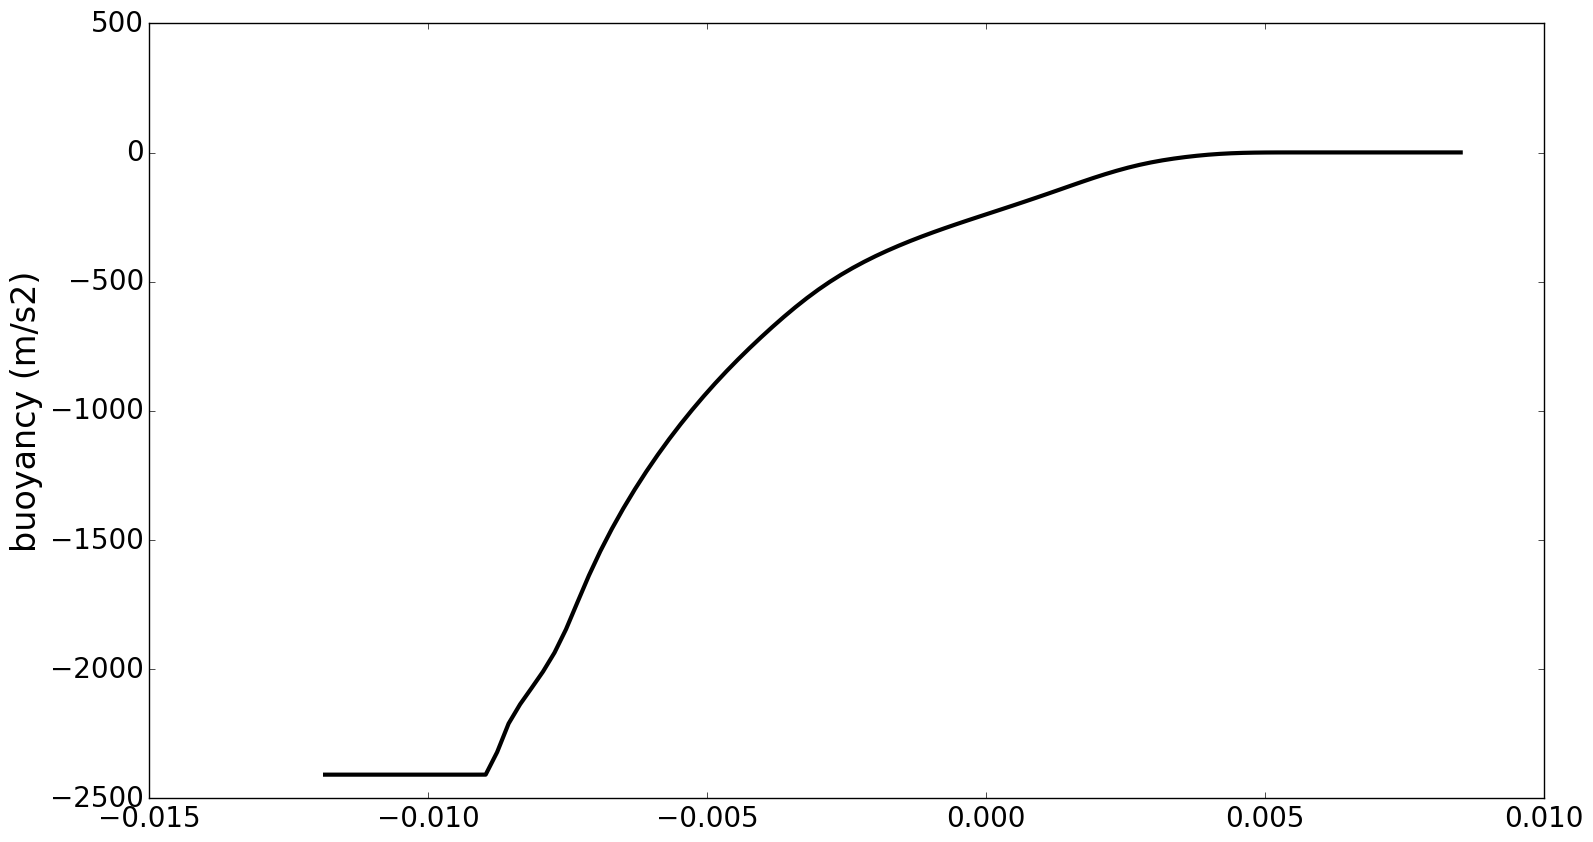

In [33]:
#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

avg_heightMidBuoyCoorEA = zeros_like(heightMidBuoyCoorEA)
avg_heightMidBuoyCoorEA = heightMidBuoyCoorEA[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_heightMidBuoyCoorEA, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_heightMidBuoyCoorEA = sumData

plt.plot(bPosition, avg_heightMidBuoyCoorEA, color='black', linewidth=3)
#plt.ylim(-0.01, 0.006)
plt.ylabel('buoyancy (m/s2)', **axis_font)

for k in range(25,60):
    print k, bPosition[k], avg_heightMidBuoyCoorEA[k]

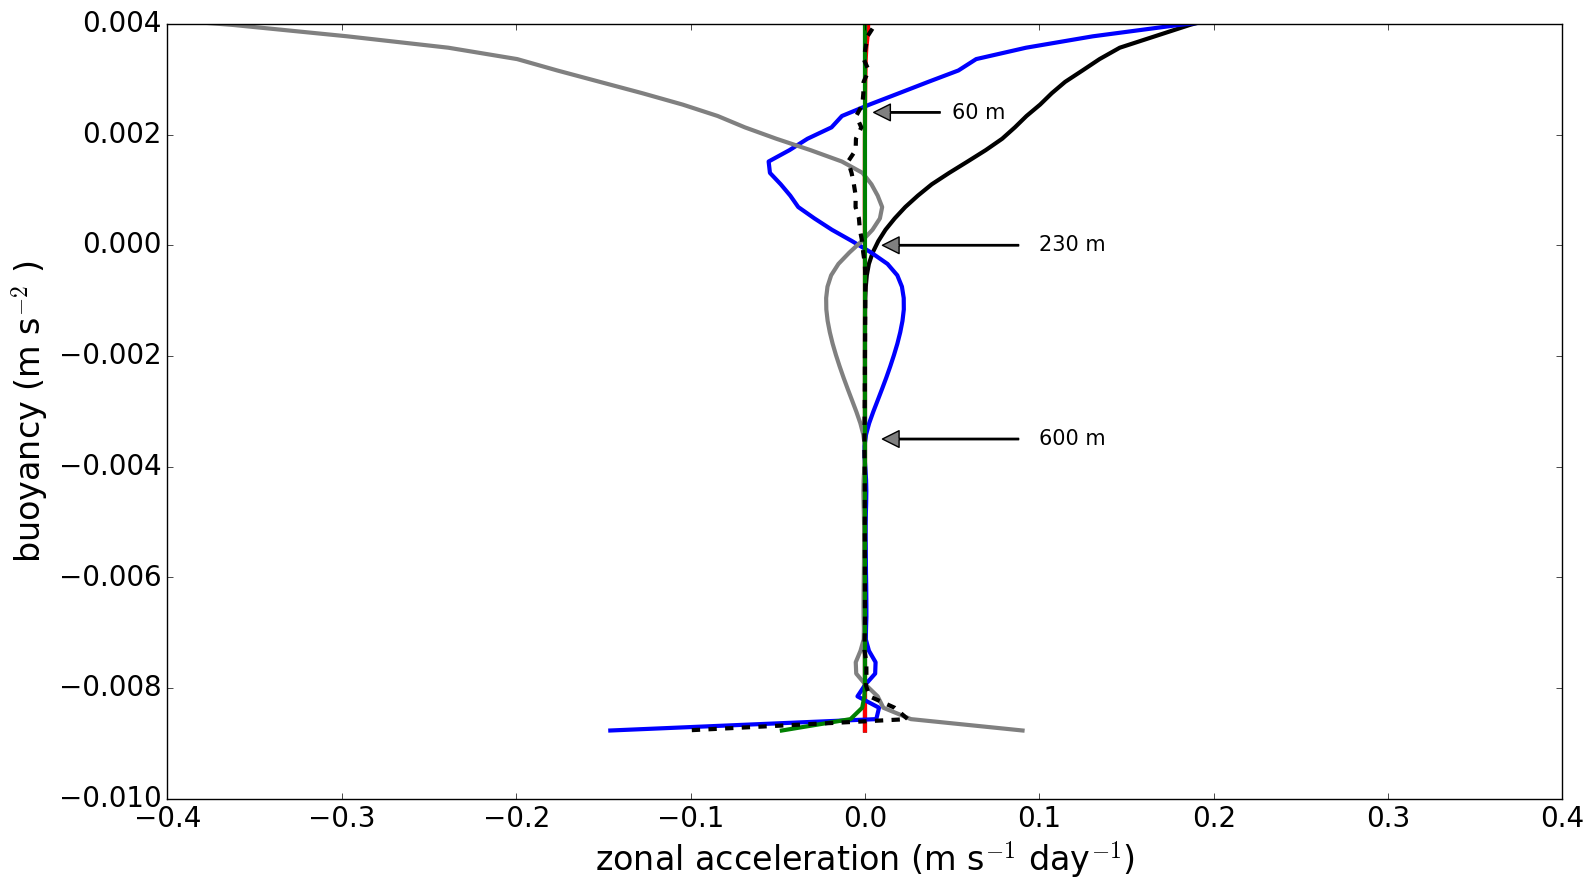

In [34]:
#plotting threshold
pThreshold = 0.04
plottingNaN = np.NaN

#avg buoyancyMaskEA in x and y
avg_windStress = zeros_like(windStressZonalLayer)
avg_windStress = windStressZonalLayer[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_windStress, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_windStress = sumData
avg_windStress = np.where(avg_buoyancyMaskEA>pThreshold, avg_windStress, plottingNaN )

avg_verticalAdvection = zeros_like(verticalAdvection)
avg_verticalAdvection = verticalAdvection[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_verticalAdvection, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_verticalAdvection = sumData
avg_verticalAdvection = np.where(avg_buoyancyMaskEA>pThreshold, avg_verticalAdvection, plottingNaN )

avg_coriolisForce = zeros_like(coriolisForce)
avg_coriolisForce = coriolisForce[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_coriolisForce, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_coriolisForce = sumData
avg_coriolisForce = np.where(avg_buoyancyMaskEA>pThreshold, avg_coriolisForce, plottingNaN )

avg_eddyForcingVert = zeros_like(eddyForcingVert)
avg_eddyForcingVert = eddyForcingVert[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_eddyForcingVert, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_eddyForcingVert = sumData
avg_eddyForcingVert = np.where(avg_buoyancyMaskEA>pThreshold, avg_eddyForcingVert, plottingNaN )

avg_divEPFT = zeros_like(divEPFT)
avg_divEPFT = divEPFT[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_divEPFT, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_divEPFT = sumData
avg_divEPFT = np.where(avg_buoyancyMaskEA>pThreshold, avg_divEPFT, plottingNaN )

avg_bottomDrag = zeros_like(bottomDrag)
avg_bottomDrag = bottomDrag[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_bottomDrag, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_bottomDrag = sumData
avg_bottomDrag = np.where(avg_buoyancyMaskEA>pThreshold, avg_bottomDrag, plottingNaN )

avg_residual = avg_windStress + avg_coriolisForce - avg_divEPFT + avg_verticalAdvection - avg_bottomDrag

plt.plot(86400.0*avg_windStress, bPosition, color='black', linewidth=3)
plt.plot(86400.0*avg_verticalAdvection, bPosition, color='red', linewidth=3)
plt.plot(86400.0*avg_coriolisForce, bPosition, color='blue', linewidth=3)
plt.plot(-86400.0*avg_divEPFT, bPosition, color='gray',linewidth=3)
plt.plot(-86400.0*avg_bottomDrag, bPosition, color='green',linewidth=3)
plt.plot(86400.0*avg_residual, bPosition, color='black',linewidth=3, linestyle='dashed')
plt.xlim(-0.4, 0.4)
plt.ylim(-0.01, 0.004)
plt.ylabel('buoyancy (m s$^{-2}$ )', **axis_font)
plt.xlabel('zonal acceleration (m s$^{-1}$ day$^{-1}$)', **axis_font)

plt.annotate('60 m', fontsize=15,
             xy=(0.0, 0.0024), xycoords='data',
             xytext=(0.05, 0.0024), textcoords='data',
             horizontalalignment='left', verticalalignment='center',
             arrowprops=dict(facecolor='gray', shrink=0.1, width=1) )

plt.annotate('230 m', fontsize=15,
             xy=(0.0, 0.0), xycoords='data',
             xytext=(0.1, 0.0), textcoords='data',
             horizontalalignment='left', verticalalignment='center',
             arrowprops=dict(facecolor='gray', shrink=0.1, width=1) )

plt.annotate('600 m', fontsize=15,
             xy=(0.0, -0.0035), xycoords='data',
             xytext=(0.1, -0.0035), textcoords='data',
             horizontalalignment='left', verticalalignment='center',
             arrowprops=dict(facecolor='gray', shrink=0.1, width=1) )

savefig('integratedForceBalance.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

In [ ]:
#meridional flux of zonal momentum
EPFT21 = bAvgData.variables['EPFT'][iTime,:,:,0,1];
EPFT21 = EPFT21.reshape(nY,nX,nBuoyancyLayers)

EPFT21 = np.multiply(EPFT21, oceanMask)

EPFT21Levels = linspace(-0.3, 0.1, 41)

maskLevels = [0.001, 0.01, 0.1, 0.25, 0.5, 0.95]

sumData = np.sum(EPFT21, axis=1);
sumData = np.divide(sumData,nX)
plotDataEPFT21 = sumData

sumData = np.sum(buoyancyMaskEA, axis=1);
sumData = np.divide(sumData,nX)
maskData = sumData  

plt.contourf(yPosition, bPosition, plotDataEPFT21.T);
plt.colorbar();
plt.contour(yPosition, bPosition, maskData.T, levels=maskLevels, colors='black');
plt.ylim(-.7, 1.05)
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [ ]:
#compute diffusivity based on buoyancy closure

#start by computing (dz/dy)|b , slope of bouyancy surface

#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

#uTWA
uTWA = bAvgData.variables['uTWA'][iTime,:,:];
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)

#vertical buoyancy flux - zonal direction
EPFT31 = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT31 = EPFT31.reshape(nY,nX,nBuoyancyLayers)

#get thickness
sigmaEA = bAvgData.variables['sigmaEA'][:]
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)

EPFT31 = np.multiply(EPFT31,sigmaEA)

#coordinates
yCell = initData.variables['yCell'][:];
yCell = yCell.reshape(nY,nX)
dY = yCell[nY/2,1]- yCell[nY/2-1,1]
print dY

#coordinates
fCell = initData.variables['fCell'][:];
fCell = fCell.reshape(nY,nX)

kappaBuoyancy = zeros_like(heightMidBuoyCoorEA)
buoyancySurfaceSlope=zeros_like(heightMidBuoyCoorEA)
for j in range(1,nY-2):
    for i in range(0,nX-1):
        for iBuoyancy in range(0,nBuoyancyLayers):
            buoyancySurfaceSlope[j,i,iBuoyancy]=(heightMidBuoyCoorEA[j+1,i,iBuoyancy]-heightMidBuoyCoorEA[j-1,i,iBuoyancy])
            buoyancySurfaceSlope[j,i,iBuoyancy]=buoyancySurfaceSlope[j,i,iBuoyancy]/dY/2.0
            kappaBuoyancy[j,i,iBuoyancy]= -np.divide(EPFT31[j,i,iBuoyancy],buoyancySurfaceSlope[j,i,iBuoyancy])
            kappaBuoyancy[j,i,iBuoyancy]=  np.divide(kappaBuoyancy[j,i,iBuoyancy],fCell[j,i])
            
sumData = np.sum(buoyancySurfaceSlope, axis=1);
sumData = np.divide(sumData,nX)
plotBuoyancySurfaceSlope = sumData

sumData = np.sum(kappaBuoyancy, axis=1);
sumData = np.divide(sumData,nX)
plotKappaBuoyancy = sumData

slopeColors = linspace(-0.2, 0.2, 101)

plt.contourf(yPosition, bPosition, 100*plotBuoyancySurfaceSlope.T, levels=slopeColors);
plt.colorbar();
plt.contour(yPosition, bPosition, maskData.T, levels=maskLevels, colors='black');
plt.ylim(-.7, 1.05)
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [ ]:
#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

#uTWA
uTWA = bAvgData.variables['uTWA'][iTime,:,:];
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)

#vertical buoyancy flux - zonal direction
EPFT31 = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT31 = EPFT31.reshape(nY,nX,nBuoyancyLayers)

#get thickness
sigmaEA = bAvgData.variables['sigmaEA'][:]
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)

EPFT31 = np.multiply(EPFT31,sigmaEA)

#coordinates
yCell = initData.variables['yCell'][:];
yCell = yCell.reshape(nY,nX)
dY = yCell[nY/2,1]- yCell[nY/2-1,1]

kappaMomentum = zeros_like(heightMidBuoyCoorEA)
shear = zeros_like(heightMidBuoyCoorEA)
for j in range(0,nY):
    for i in range(0,nX):
        for iBuoyancy in range(1,nBuoyancyLayers-1):
            dz=np.maximum(heightMidBuoyCoorEA[j,i,iBuoyancy-1]-heightMidBuoyCoorEA[j,i,iBuoyancy+1], 1.0e-7)
            shear[j,i,iBuoyancy] = np.divide(uTWA[j,i,iBuoyancy-1]-uTWA[j,i,iBuoyancy+1],dz)
            shear[j,i,iBuoyancy] = np.maximum(shear[j,i,iBuoyancy], 1.0e-10)
            kappaMomentum[j,i,iBuoyancy]= -np.divide(EPFT31[j,i,iBuoyancy],shear[j,i,iBuoyancy])

In [ ]:
avg_buoyancySurfaceSlope = zeros_like(buoyancySurfaceSlope)
avg_buoyancySurfaceSlope = buoyancySurfaceSlope[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_buoyancySurfaceSlope, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_buoyancySurfaceSlope = sumData

avg_kappaBuoyancy = zeros_like(kappaBuoyancy)
avg_kappaBuoyancy = kappaBuoyancy[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_kappaBuoyancy, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_kappaBuoyancy = sumData

avg_kappaMomentum = zeros_like(kappaMomentum)
avg_kappaMomentum = kappaMomentum[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_kappaMomentum, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_kappaMomentum = sumData

avg_shear = zeros_like(shear)
avg_shear = shear[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_shear, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_shear = sumData
print avg_shear
   
avg_sigmaEA = zeros_like(sigmaEA)
avg_sigmaEA = sigmaEA[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_sigmaEA, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_sigmaEA = sumData
avg_N2EA = where(np.divide(1.0,avg_sigmaEA)<1.0, np.divide(1.0,avg_sigmaEA), 0.0 )

#plt.plot(np.log10(avg_shear), bPosition, color='black', linewidth=3)
#plt.xlim(-6,0)
plt.plot(avg_kappaMomentum, bPosition, color='black', linewidth=3)
#plt.plot(log10(avg_N2EA), bPosition, color='black', linewidth=3)
plt.ylim(-0.01, 0.004)
plt.ylabel('buoyancy (m/s2)', **axis_font)

In [ ]:
#compute diffusivity based on PV closure

#start by computing (d sigma /dy)|b , slope of bouyancy surface

#vertical buoyancy flux - zonal direction
EPFT31 = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT31 = EPFT31.reshape(nY,nX,nBuoyancyLayers)

#get thickness
sigmaEA = bAvgData.variables['sigmaEA'][:]
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)

#weight with sigma
EPFT31 = np.multiply(EPFT31,sigmaEA)

#coordinates
yCell = initData.variables['yCell'][:];
yCell = yCell.reshape(nY,nX)
dY = yCell[nY/2,1]- yCell[nY/2-1,1]
print dY

#coordinates
fCell = initData.variables['fCell'][:];
fCell = fCell.reshape(nY,nX)
beta = 1.0e-11

kappaQ = zeros_like(heightMidBuoyCoorEA)
dQdY = zeros_like(heightMidBuoyCoorEA)
work1 = zeros_like(heightMidBuoyCoorEA)
work2 = zeros_like(heightMidBuoyCoorEA)

for j in range(1,nY-2):
    for i in range(0,nX-1):
        for iBuoyancy in range(0,nBuoyancyLayers):
            work1[j,i,iBuoyancy] =  sigmaEA[j+1,i,iBuoyancy]-sigmaEA[j-1,i,iBuoyancy]
            work1[j,i,iBuoyancy] = work1[j,i,iBuoyancy]/dY/2.0
            work2[j,i,iBuoyancy] = -np.multiply(sigmaEA[j,i,iBuoyancy],sigmaEA[j,i,iBuoyancy])
            dQdY[j,i,iBuoyancy] = np.divide(work1[j,i,iBuoyancy], work2[j,i,iBuoyancy])
            dQdY[j,i,iBuoyancy] =  np.multiply(fCell[j,1],dQdY[j,i,iBuoyancy])
            dQdY[j,i,iBuoyancy] = dQdY[j,i,iBuoyancy] + np.divide(beta,sigmaEA[j,i,iBuoyancy])
        

In [ ]:
sumData = np.sum(dQdY, axis=1);
sumData = np.divide(sumData,nX)
plotdQdY = where(sumData>2.0e-18, sumData, 2.0e-18)

dQdYColors = linspace(-18,-10,101)

plt.contourf(yPosition, bPosition, np.log10(plotdQdY.T), cmap=plt.cm.binary, levels=dQdYColors);
plt.colorbar();
plt.contour(yPosition, bPosition, maskData.T, levels=maskLevels, colors='black');
plt.ylim(-.7, 1.05)
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [ ]:
avg_dQdY = zeros_like(dQdY)
avg_dQdY = dQdY[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_dQdY, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_dQdY = sumData

plt.plot(np.log10(avg_dQdY), bPosition, color='black', linewidth=3)
plt.ylim(-0.01, 0.004)
plt.ylabel('buoyancy (m/s2)', **axis_font)

In [ ]:
avg_divEPFT = zeros_like(divEPFT)
avg_divEPFT = np.divide(divEPFT[index_yPositionMin:index_yPositionMax,:,:], sigmaEA[index_yPositionMin:index_yPositionMax,:,:])
sumData = np.sum(np.sum(avg_divEPFT, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_divEPFT = sumData
avg_divEPFT = np.where(avg_buoyancyMaskEA>pThreshold, avg_divEPFT, plottingNaN )

plt.plot(np.log10(avg_divEPFT), bPosition, color='black', linewidth=3)
plt.ylim(-0.01, 0.004)
plt.ylabel('buoyancy (m/s2)', **axis_font)


In [ ]:
avg_kappaQ = zeros_like(divEPFT)
work1 = zeros_like(divEPFT)
work2 = zeros_like(divEPFT)
print work1.shape

work1 = np.divide(divEPFT[:,:,:], sigmaEA[:,:,:])*10.0e15
work2 = dQdY[:,:,:]*10.0e15

work3 = work1[index_yPositionMin:index_yPositionMax,:,:]
sumData3 = np.sum(np.sum(work3, axis=1), axis=0)
sumData3 = np.divide(sumData3,nX*(index_yPositionMax-index_yPositionMin))

work4 = work2[index_yPositionMin:index_yPositionMax,:,:]
sumData4 = np.sum(np.sum(work4, axis=1), axis=0)
sumData4 = np.divide(sumData4,nX*(index_yPositionMax-index_yPositionMin))

avg_kappaQ = np.divide(sumData3,sumData4)
avg_kappaQ = np.where(avg_buoyancyMaskEA>pThreshold, avg_kappaQ, plottingNaN )

plt.plot(avg_kappaQ, bPosition, color='black', linewidth=3)
plt.ylim(-0.003, 0.005)
plt.xlim(0,6000)
plt.ylabel('buoyancy (m/s2)', **axis_font)